# Rock-Paper-Scissors classification

## Using Tensorflow for creating a model that predicts the hand gesture for the "rock-paper-scissors" game

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import time
import random

# Configuration variables

In [13]:
# Config
input_size = 150
dataset_path = 'rock_paper_scissors_dataset'
dataset_train_path = os.path.join(dataset_path, 'train')
classes = ['rock', 'paper', 'scissors']
no_display_images = 5

# Sample dataset visualization

### Dataset source: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset

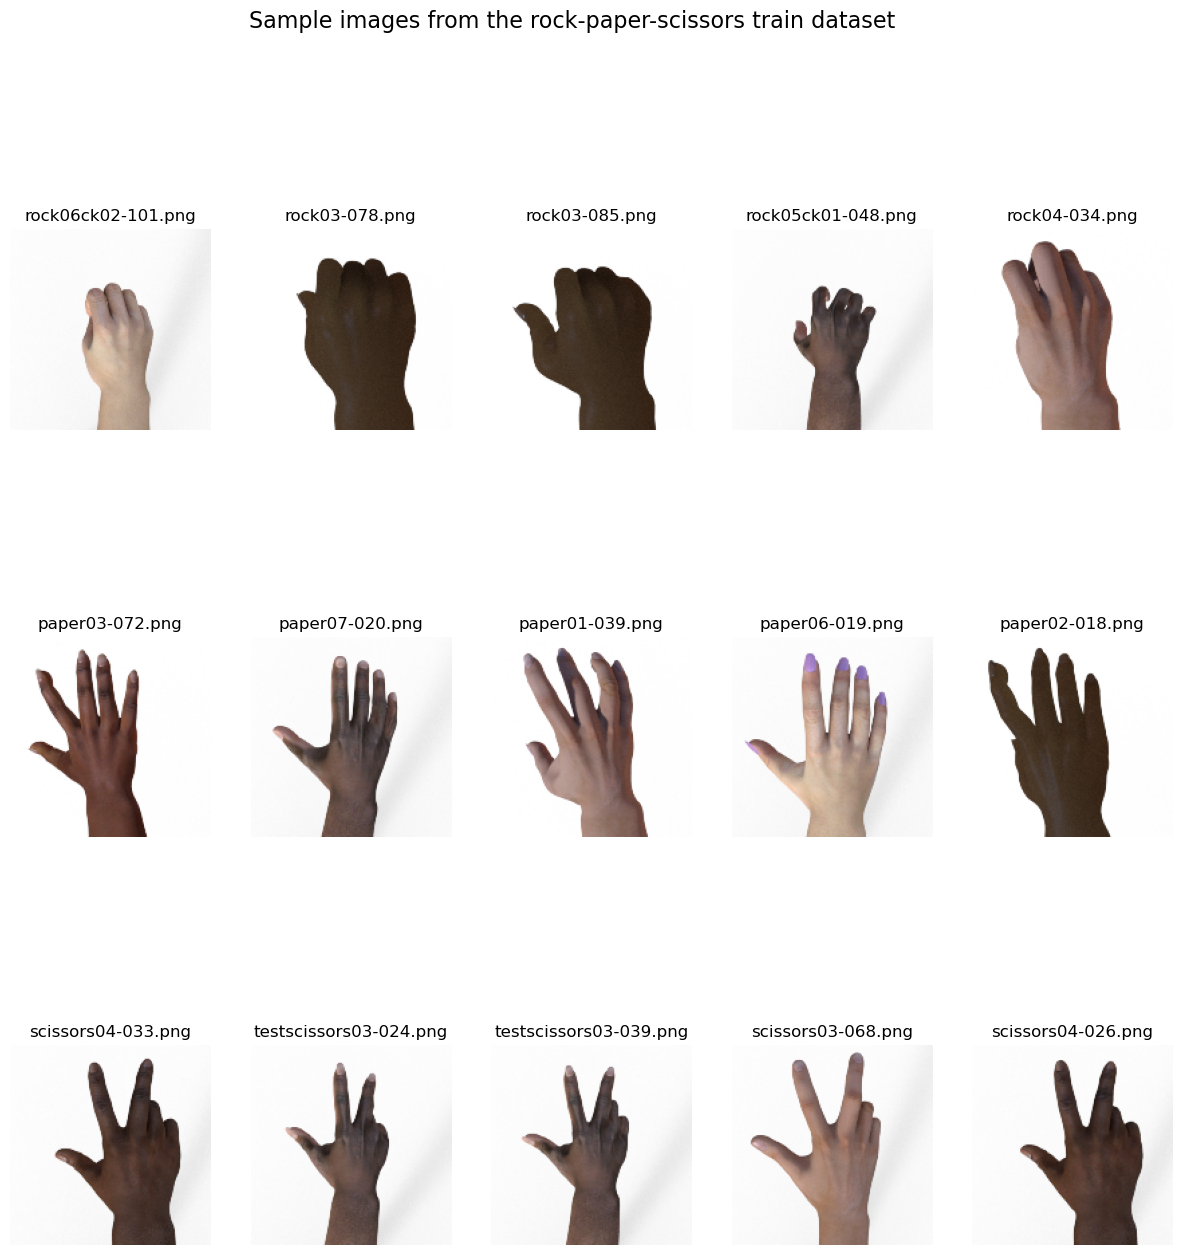

In [50]:
# Sample dataset
classes_folders_dict = {}
classes_files_dict = {}
for cls in classes:
    classes_folders_dict[cls] = os.path.join(dataset_train_path, cls)
    classes_files_dict[cls] = os.listdir(classes_folders_dict[cls])

list_sample_images_filepath = []

for cls in classes:
    list_class = []
    for idx in range(no_display_images):
        random_number = random.randint(0,len(classes_files_dict[cls])-1)
        list_class.append(classes_files_dict[cls][random_number])
    list_sample_images_filepath.append(list_class)


fig, axs = plt.subplots(len(classes), no_display_images,figsize=(15, 15))
fig.suptitle('Sample images from the rock-paper-scissors train dataset', fontsize=16)

#fig.tight_layout(pad=0.5)
for row,cls in enumerate(classes):
    for col,file in enumerate(list_sample_images_filepath[row]):
        img = load_img(os.path.join(classes_folders_dict[cls],file), target_size=(input_size,input_size))
        axs[row, col].imshow(img)
        axs[row, col].set_title(f'{file}')
        axs[row, col].axis('off')
    


# Exploratory Data Analysis on Images

## Mean image

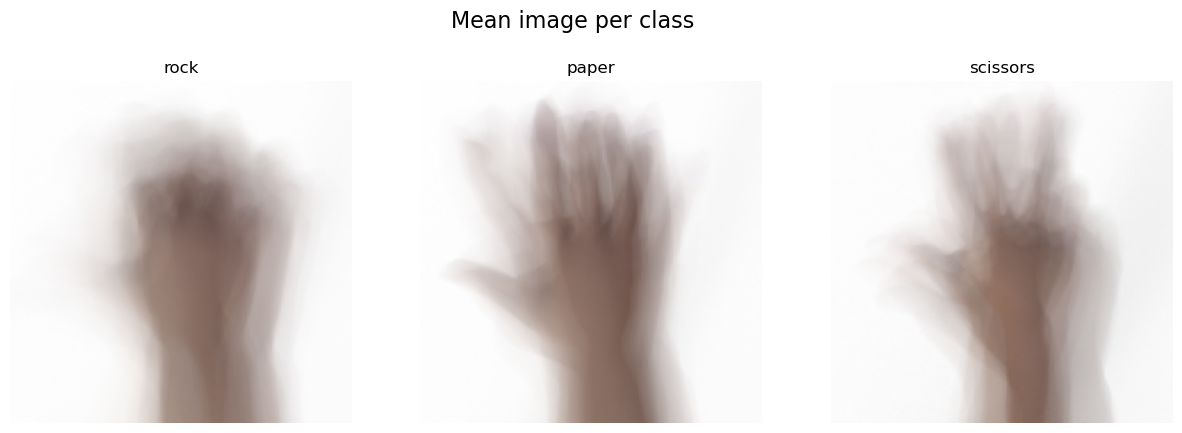

In [49]:
def get_mean_image(folder, input_size):
    mean_image = np.zeros((input_size, input_size, 3))
    files = os.listdir(folder)
    for f in files:
        img = load_img(os.path.join(folder,f), target_size=(input_size,input_size))
        image = np.array(img, dtype=np.float32) / len(files)
        mean_image = mean_image + image
    return mean_image / 255

mean_images = np.zeros((len(classes), input_size, input_size, 3))

fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
fig.suptitle('Mean image per class', fontsize=16)

for idx, cls in enumerate(classes):
    mean_images[idx] = get_mean_image(classes_folders_dict[cls], input_size)
    axs[idx].imshow(mean_images[idx])
    axs[idx].set_title(cls)
    axs[idx].axis('off')

## Contrast between mean images

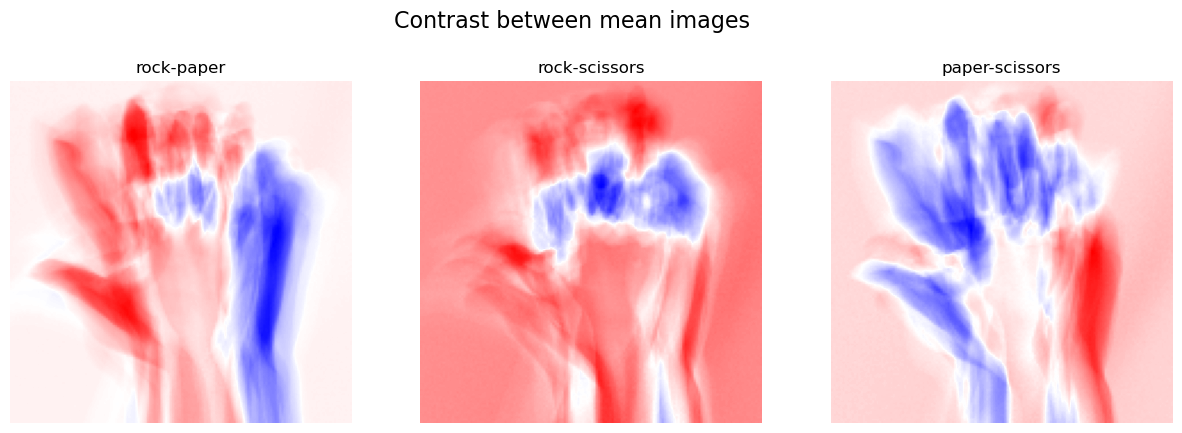

In [48]:
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
fig.suptitle('Contrast between mean images', fontsize=16)
count = -1
for idx_1 in range(len(classes)):
    for idx_2 in range(len(classes)):
        if idx_1 >= idx_2: 
            continue
        count += 1
        contrast_image = mean_images[idx_1] - mean_images[idx_2]
        axs[count].imshow(np.mean(contrast_image, axis=-1), cmap='bwr')
        axs[count].set_title(f'{classes[idx_1]}-{classes[idx_2]}')
        axs[count].axis('off')

# Model training

In [65]:
img = np.array(img)
# Preprocessing
def custom_preprocess_input(image):
    #image_gray = image.convert("L")
    image_array = np.array(image, dtype=np.float32) / 255
    image_array = np.dot(image_array[...,:3], [0.2989, 0.5870, 0.1140])
    return np.expand_dims(image_array,-1)

custom_preprocess_input(img).shape

(150, 150, 1)

## Data generators

In [34]:
# Image generators
train_val_gen = ImageDataGenerator(
                rescale=1./255,
                #preprocessing_function=preprocess_input,
                rotation_range=10,
                width_shift_range=10,
                height_shift_range=10,
                shear_range=10,
                zoom_range=0.2,
                horizontal_flip=False,
                vertical_flip=False,
                validation_split=0.2)

train_ds = train_val_gen.flow_from_directory('./rock_paper_scissors_dataset/train', 
                                         target_size=(input_size,input_size),
                                         batch_size=32,
                                         class_mode='categorical',
                                         color_mode='grayscale',
                                         #color_mode='rgb',
                                        subset='training'
                                        )

#val_gen = ImageDataGenerator(rescale=1./255)

val_ds = train_val_gen.flow_from_directory('./rock_paper_scissors_dataset/train', 
                                         target_size=(input_size,input_size),
                                         batch_size=1,
                                         shuffle=False,
                                         class_mode='categorical',
                                         color_mode='grayscale',
                                         #color_mode='rgb'
                                        subset='validation'
                                        )

#test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(rescale=1./255)
test_ds = test_gen.flow_from_directory('./rock_paper_scissors_dataset/test', 
                                         target_size=(input_size,input_size),
                                         shuffle=False,
                                         batch_size=1,
                                         class_mode='categorical',
                                         color_mode='grayscale'
                                         #  color_mode='rgb'
                                           )    

print(train_ds.class_indices)
X, y = next(train_ds)
X.shape
#preprocess_input(X).shape

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
{'paper': 0, 'rock': 1, 'scissors': 2}


(32, 150, 150, 1)

## Function for creating the model

In [36]:
# Create model function
def make_model(base_model_type = 'custom', 
               input_size = 150, 
               learning_rate = 1e-3, 
               num_classes = 2, 
               size_dense_1 = 256,
               size_dense_2 = 64, 
               drop_rate=0.2):
    
    inputs = keras.Input(shape=(input_size,input_size,1))

    if base_model_type == 'xception':
        base_model = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=(input_size,input_size,3))
        base_model.trainable = False
        inputs = keras.Input(shape=(input_size,input_size,3))
        base = base_model(inputs)
        vectors = keras.layers.GlobalAveragePooling2D()(base)
        inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
        drop = keras.layers.Dropout(drop_rate)(inner)
        outputs = keras.layers.Dense(num_classes)(drop)
        if num_classes <= 2:
            loss = keras.losses.BinaryCrossentropy(from_logits=True)
        elif num_classes > 2:
            loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    elif base_model_type == 'custom':
        conv2d_1 = keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu')(inputs)
        maxpool2d_1 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))(conv2d_1)
        dropout_1 = keras.layers.Dropout(drop_rate)(maxpool2d_1)
        conv2d_2 = keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu')(dropout_1)
        maxpool2d_2 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))(conv2d_2)
        dropout_2 = keras.layers.Dropout(drop_rate)(maxpool2d_2)
        conv2d_3 = keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu')(dropout_2)
        maxpool2d_3 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))(conv2d_3)
        dropout_3 = keras.layers.Dropout(drop_rate)(maxpool2d_3)
        flatten_1 = tf.keras.layers.Flatten()(dropout_3)
        dense_1 = tf.keras.layers.Dense(size_dense_1, activation='relu', kernel_regularizer='l2')(flatten_1)
        dense_2 = tf.keras.layers.Dense(size_dense_2, activation='relu', kernel_regularizer='l2')(dense_1)

        #outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_1)
        outputs = tf.keras.layers.Dense(num_classes, kernel_regularizer='l2', activation='softmax')(dense_2)
        #loss = keras.losses.BinaryCrossentropy()
        loss = keras.losses.CategoricalCrossentropy()
    else:
        print("Model not implemented.")
        return None
    
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

## Run multiple experiments

Training model v1 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.0, learning_rate=0.01]
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_108 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_108 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_109 (Conv2D)         (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_109 (MaxPooli 

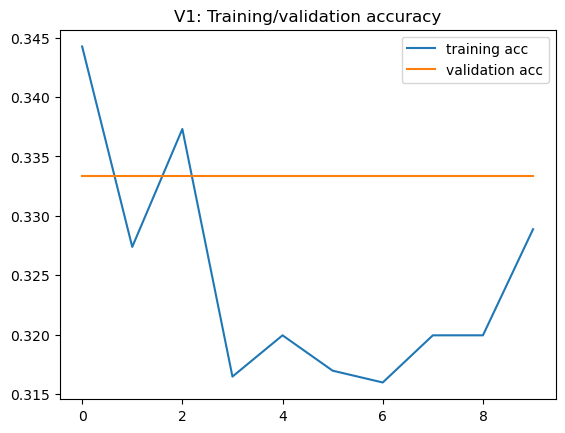

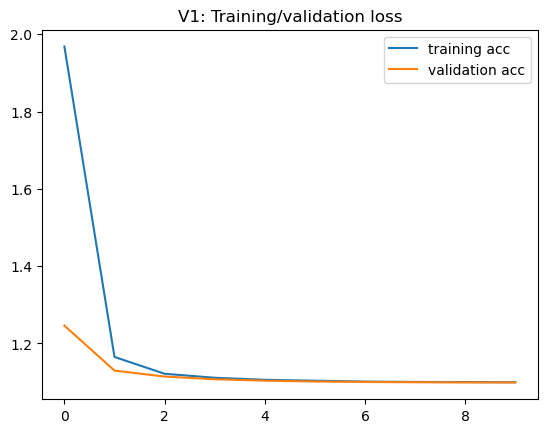

372/372 [==============================] - 4s 10ms/step - loss: 1.0990 - accuracy: 0.3333
Training model v2 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.0, learning_rate=0.001]
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_111 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_111 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_112 (Conv2D)         (None, 72, 72, 32)        9248      
    

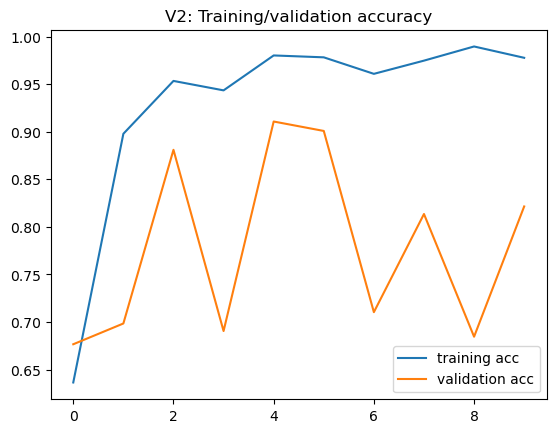

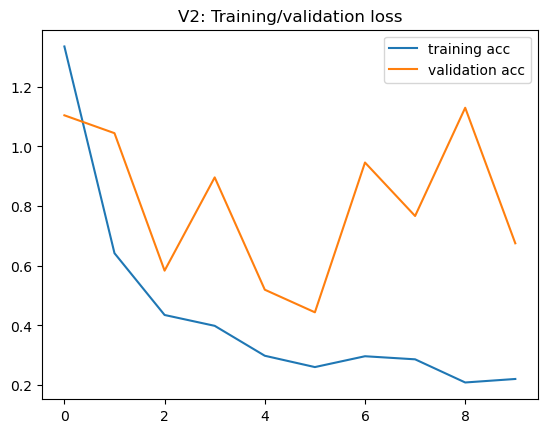

372/372 [==============================] - 5s 14ms/step - loss: 0.2656 - accuracy: 0.9704
Training model v3 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.0, learning_rate=0.0001]
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_114 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_114 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_115 (Conv2D)         (None, 72, 72, 32)        9248      
   

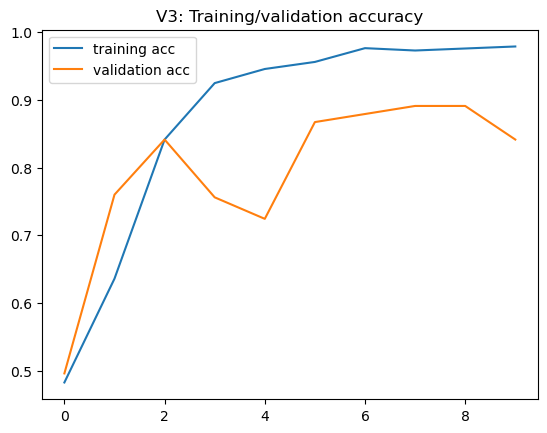

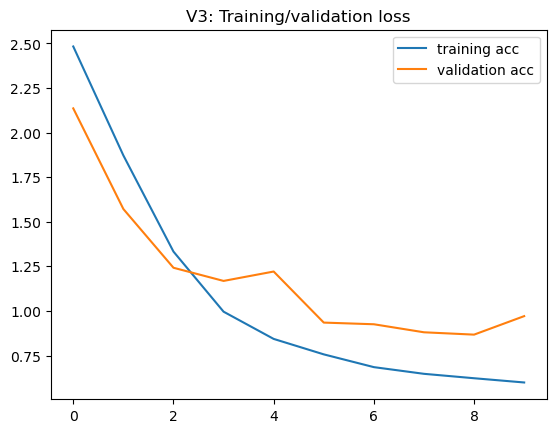

372/372 [==============================] - 4s 9ms/step - loss: 0.6083 - accuracy: 0.9758
Training model v4 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.2, learning_rate=0.01]
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_117 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_117 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_117 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_118 (Conv2D)         (None, 72, 72, 32)        9248      
      

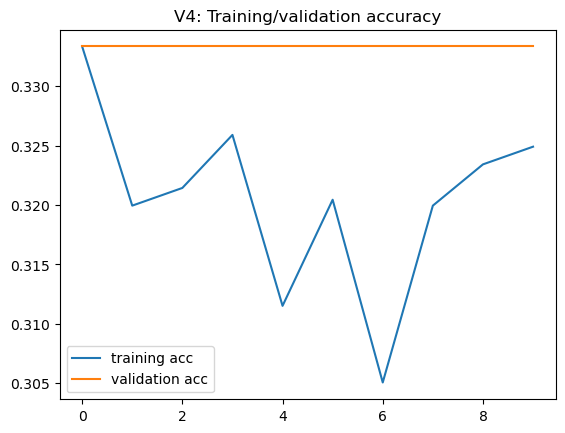

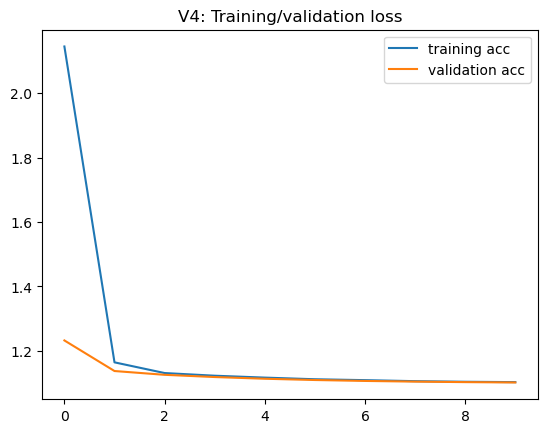

372/372 [==============================] - 3s 9ms/step - loss: 1.1015 - accuracy: 0.3333
Training model v5 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.2, learning_rate=0.001]
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_120 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_120 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_121 (Conv2D)         (None, 72, 72, 32)        9248      
     

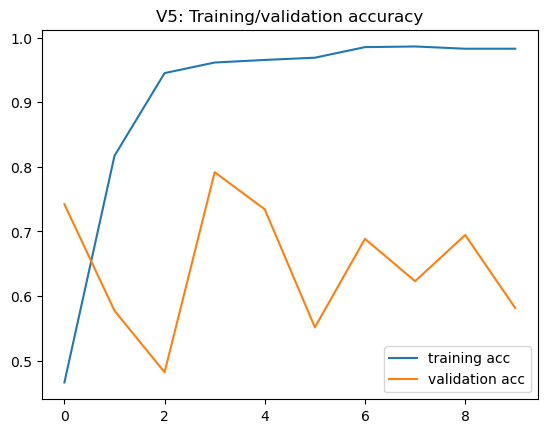

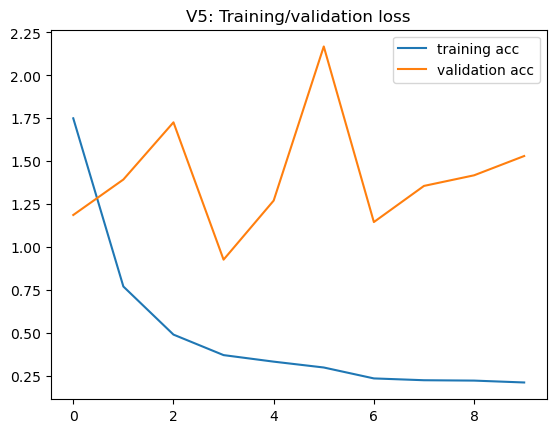

372/372 [==============================] - 4s 10ms/step - loss: 0.2201 - accuracy: 0.9758
Training model v6 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.2, learning_rate=0.0001]
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_123 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_123 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_124 (Conv2D)         (None, 72, 72, 32)        9248      
   

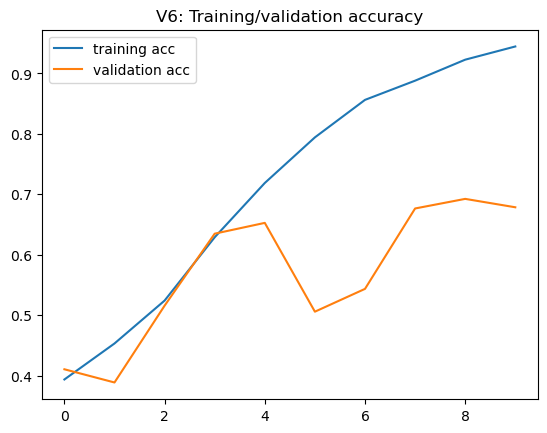

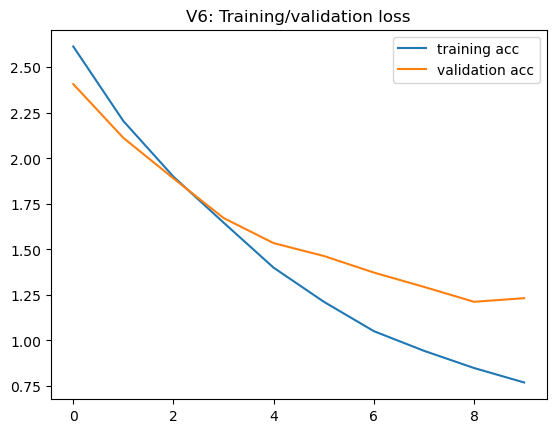

372/372 [==============================] - 4s 10ms/step - loss: 0.8755 - accuracy: 0.8468
Training model v7 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.5, learning_rate=0.01]
Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_126 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_126 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_127 (Conv2D)         (None, 72, 72, 32)        9248      
     

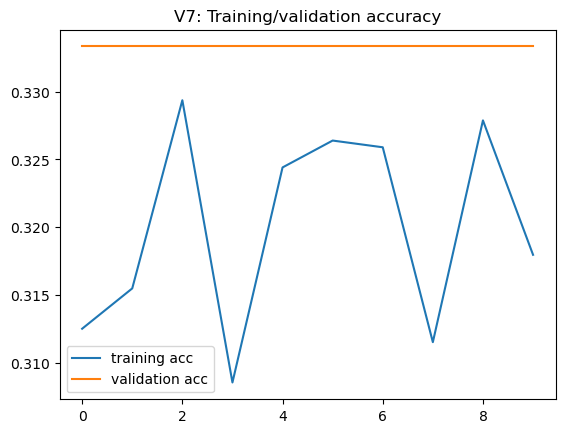

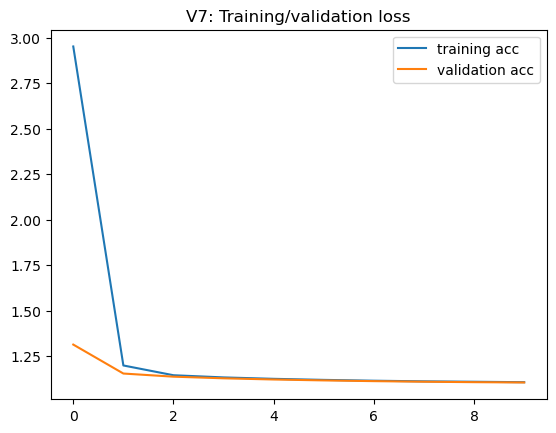

372/372 [==============================] - 3s 9ms/step - loss: 1.1058 - accuracy: 0.3333
Training model v8 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.5, learning_rate=0.001]
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_129 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_129 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_130 (Conv2D)         (None, 72, 72, 32)        9248      
     

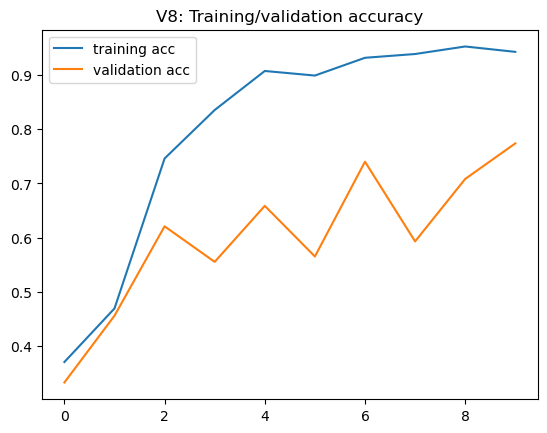

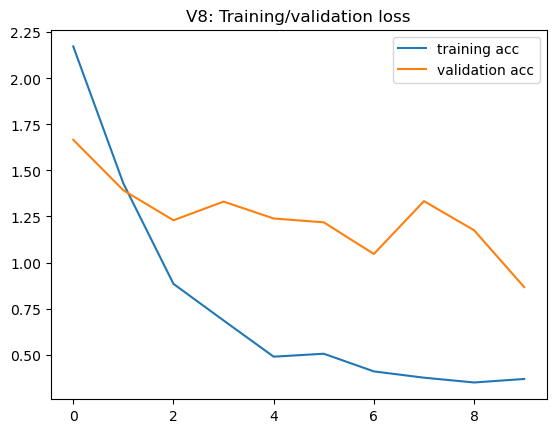

372/372 [==============================] - 4s 11ms/step - loss: 0.3757 - accuracy: 0.9409
Training model v9 (/54)! [size_dense_1=64, size_dense_2=32, drop_rate=0.5, learning_rate=0.0001]
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_132 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_132 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_132 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_133 (Conv2D)         (None, 72, 72, 32)        9248      
   

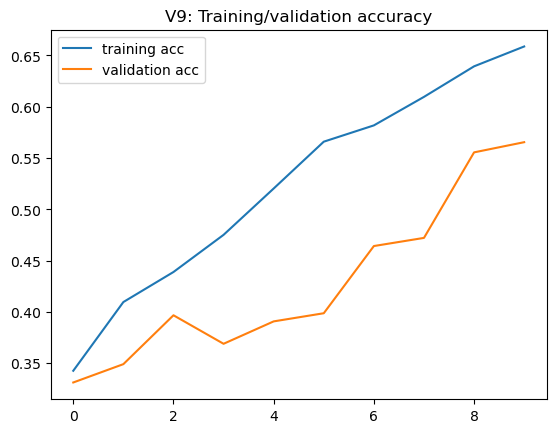

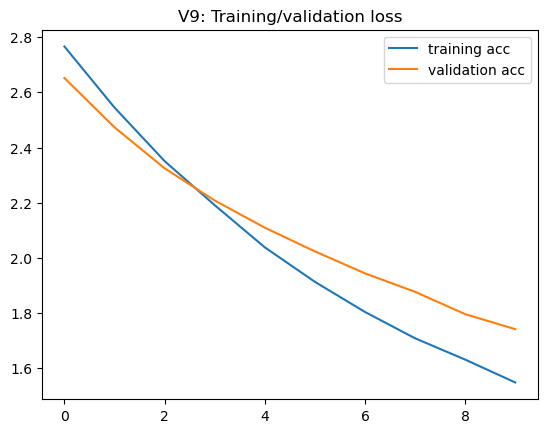

372/372 [==============================] - 4s 11ms/step - loss: 1.7291 - accuracy: 0.5242
Training model v10 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.0, learning_rate=0.01]
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_135 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_135 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_136 (Conv2D)         (None, 72, 72, 32)        9248      
    

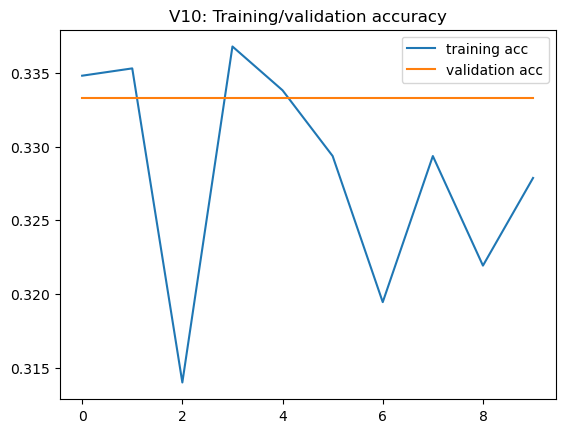

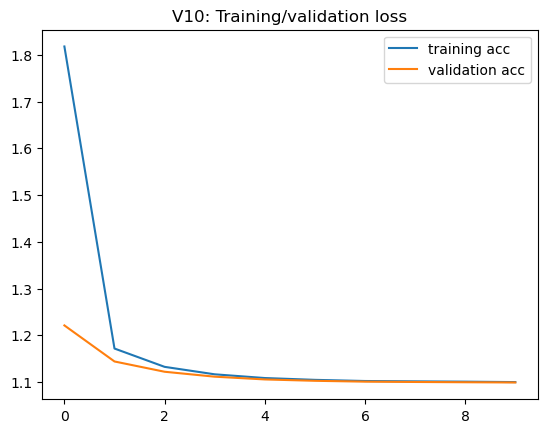

372/372 [==============================] - 4s 11ms/step - loss: 1.0991 - accuracy: 0.3333
Training model v11 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.0, learning_rate=0.001]
Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_138 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_138 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_139 (Conv2D)         (None, 72, 72, 32)        9248      
   

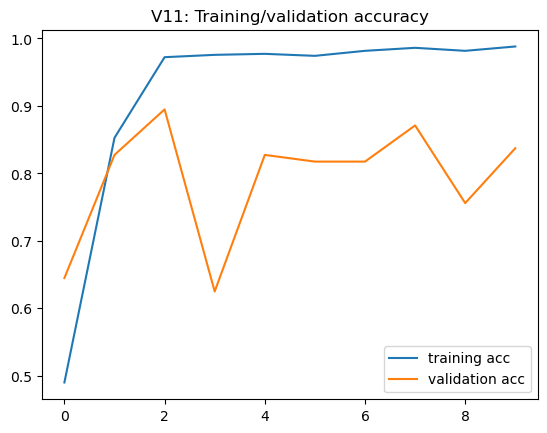

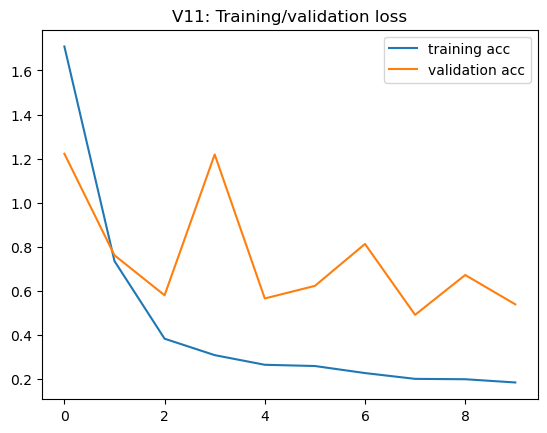

372/372 [==============================] - 7s 17ms/step - loss: 0.2181 - accuracy: 0.9866
Training model v12 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.0, learning_rate=0.0001]
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_141 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_141 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_141 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_142 (Conv2D)         (None, 72, 72, 32)        9248      
  

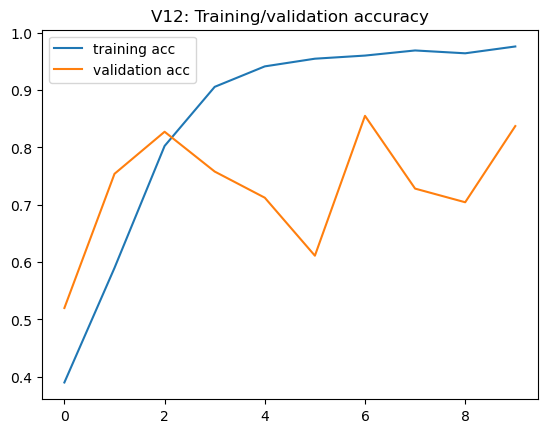

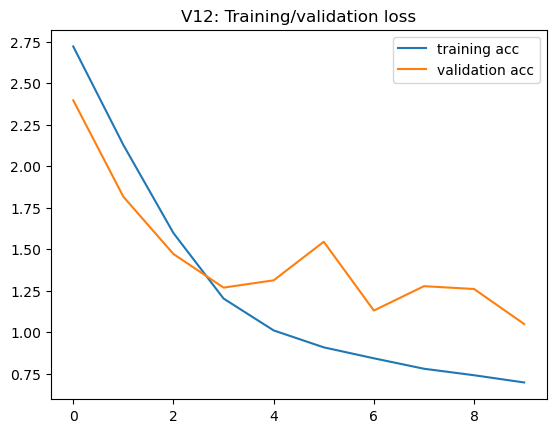

372/372 [==============================] - 3s 9ms/step - loss: 0.7004 - accuracy: 0.9624
Training model v13 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.2, learning_rate=0.01]
Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_144 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_144 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_145 (Conv2D)         (None, 72, 72, 32)        9248      
     

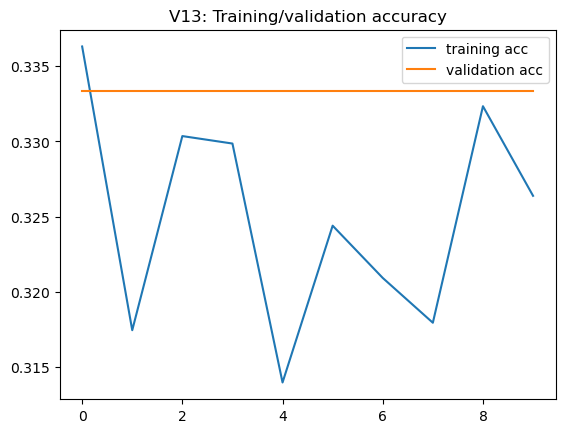

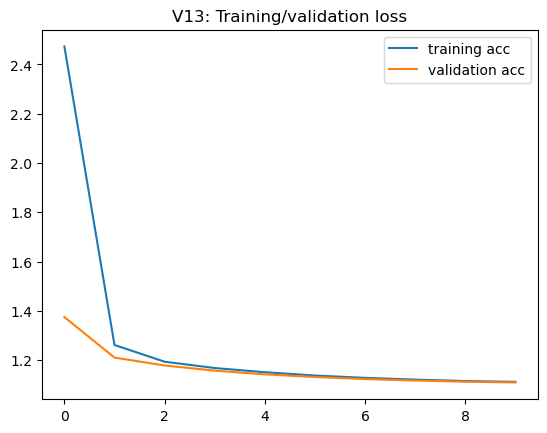

372/372 [==============================] - 3s 9ms/step - loss: 1.1096 - accuracy: 0.3333
Training model v14 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.2, learning_rate=0.001]
Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_147 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_147 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_148 (Conv2D)         (None, 72, 72, 32)        9248      
    

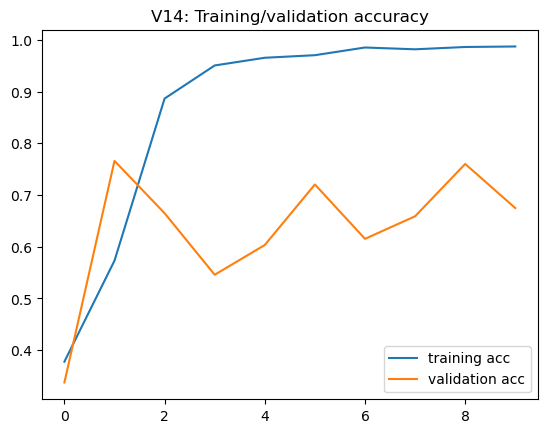

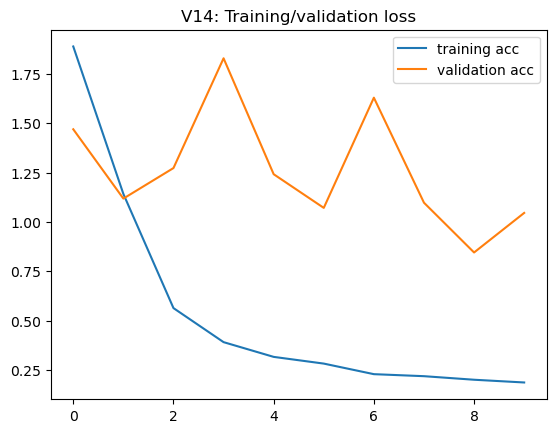

372/372 [==============================] - 4s 9ms/step - loss: 0.2080 - accuracy: 0.9758
Training model v15 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.2, learning_rate=0.0001]
Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_150 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_150 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_151 (Conv2D)         (None, 72, 72, 32)        9248      
   

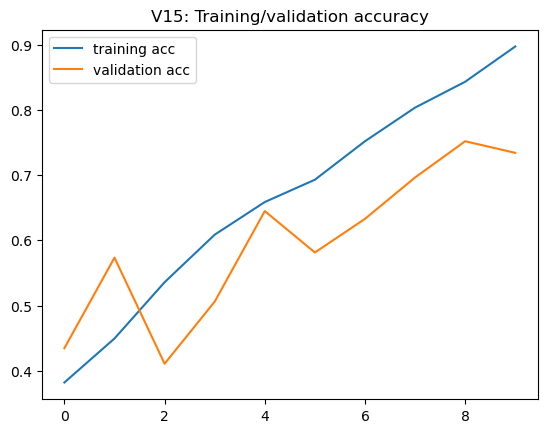

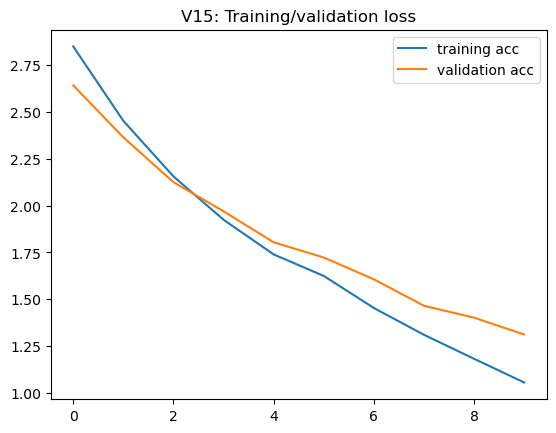

372/372 [==============================] - 3s 9ms/step - loss: 1.1829 - accuracy: 0.7876
Training model v16 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.5, learning_rate=0.01]
Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_153 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_153 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_154 (Conv2D)         (None, 72, 72, 32)        9248      
     

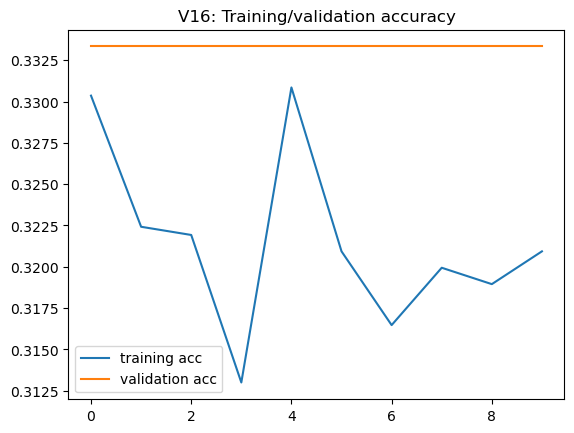

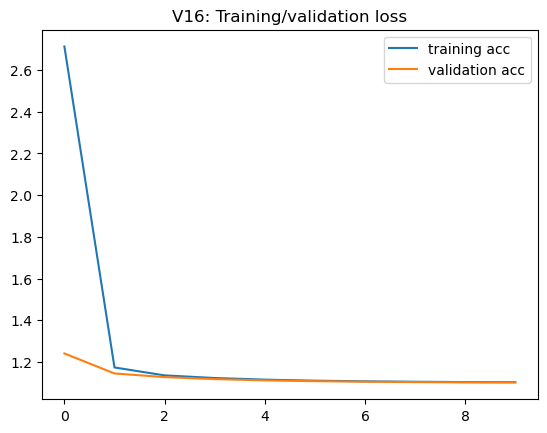

372/372 [==============================] - 3s 9ms/step - loss: 1.1017 - accuracy: 0.3333
Training model v17 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.5, learning_rate=0.001]
Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_156 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_156 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_156 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_157 (Conv2D)         (None, 72, 72, 32)        9248      
    

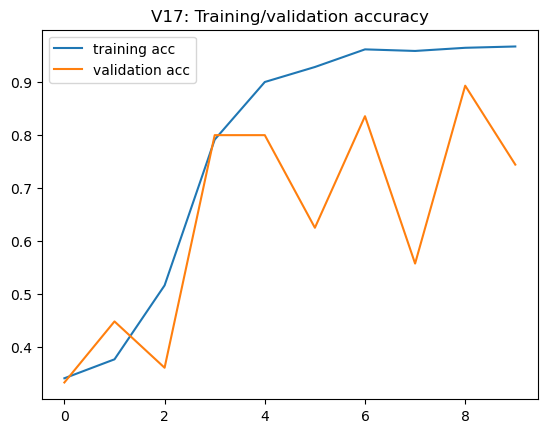

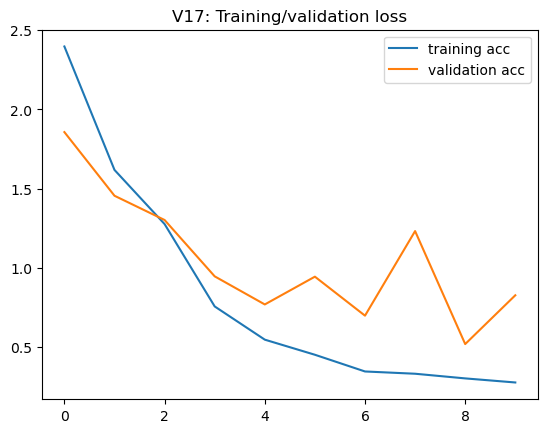

372/372 [==============================] - 4s 11ms/step - loss: 0.2461 - accuracy: 1.0000
Training model v18 (/54)! [size_dense_1=64, size_dense_2=64, drop_rate=0.5, learning_rate=0.0001]
Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_159 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_159 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_159 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_160 (Conv2D)         (None, 72, 72, 32)        9248      
  

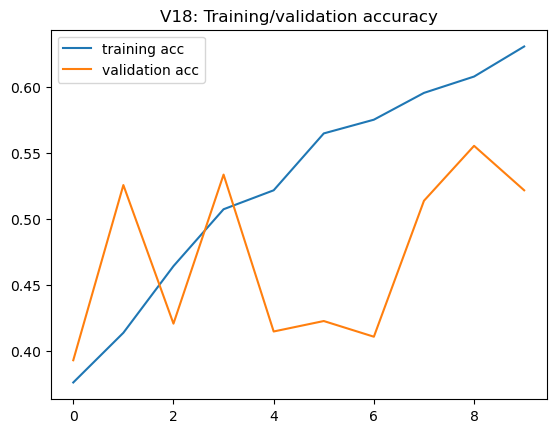

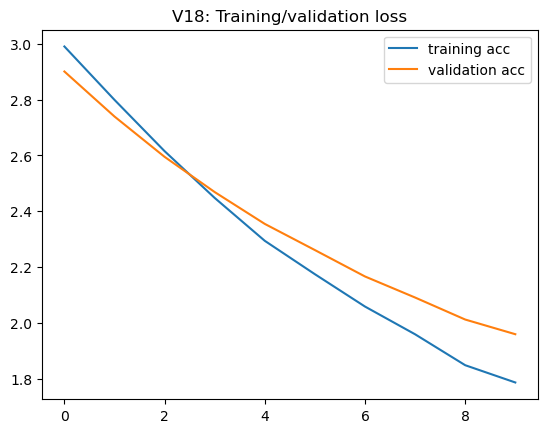

372/372 [==============================] - 4s 10ms/step - loss: 1.9483 - accuracy: 0.5000
Training model v19 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.0, learning_rate=0.01]
Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_162 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_162 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_162 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_163 (Conv2D)         (None, 72, 72, 32)        9248      
   

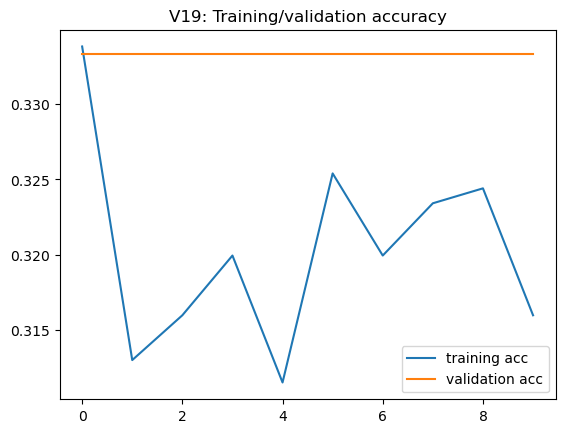

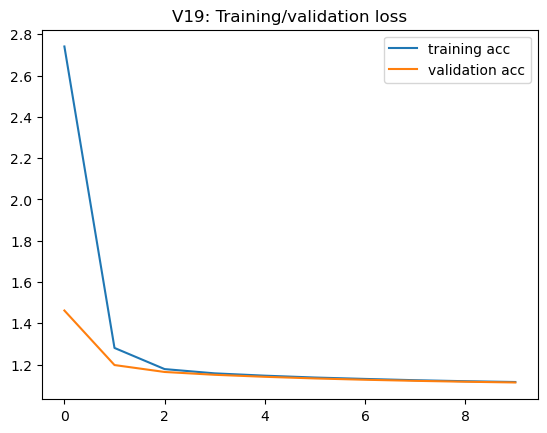

372/372 [==============================] - 3s 9ms/step - loss: 1.1131 - accuracy: 0.3333
Training model v20 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.0, learning_rate=0.001]
Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_165 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_165 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_165 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_166 (Conv2D)         (None, 72, 72, 32)        9248      
   

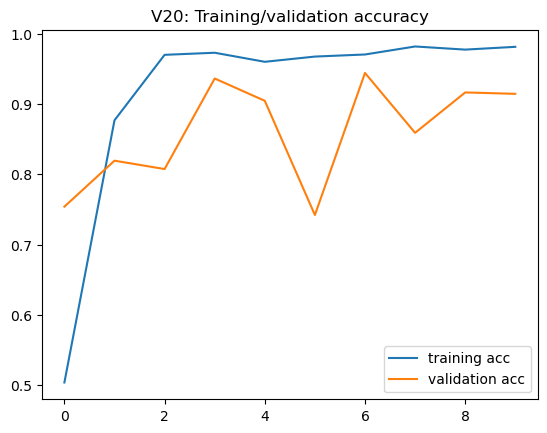

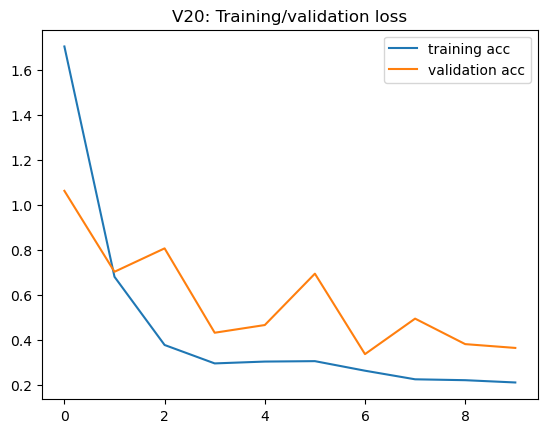

372/372 [==============================] - 3s 9ms/step - loss: 0.2690 - accuracy: 0.9651
Training model v21 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.0, learning_rate=0.0001]
Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_168 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_168 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_168 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_169 (Conv2D)         (None, 72, 72, 32)        9248      
  

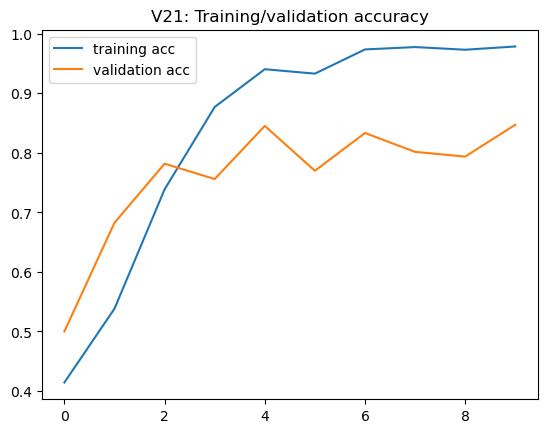

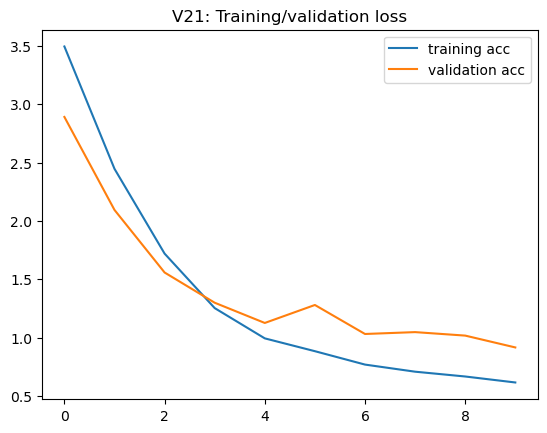

372/372 [==============================] - 3s 9ms/step - loss: 0.6616 - accuracy: 0.9489
Training model v22 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.2, learning_rate=0.01]
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_171 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_171 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_171 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_172 (Conv2D)         (None, 72, 72, 32)        9248      
    

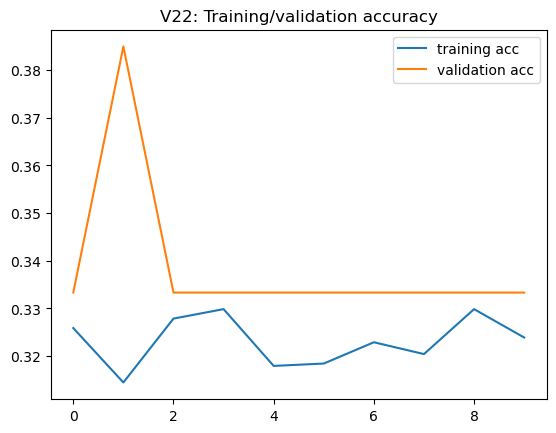

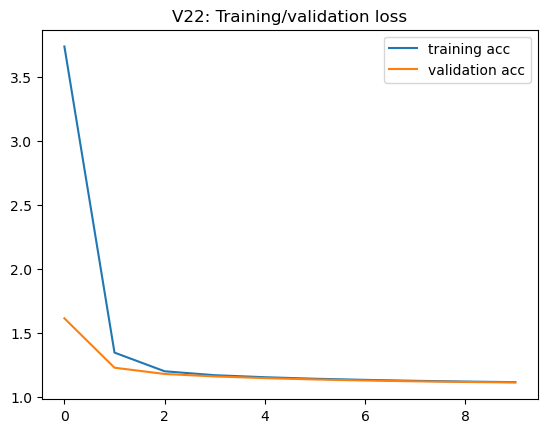

372/372 [==============================] - 4s 10ms/step - loss: 1.1156 - accuracy: 0.3333
Training model v23 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.2, learning_rate=0.001]
Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_174 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_174 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_174 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_175 (Conv2D)         (None, 72, 72, 32)        9248      
  

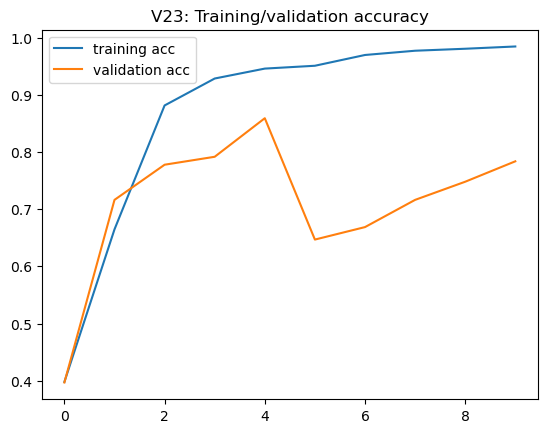

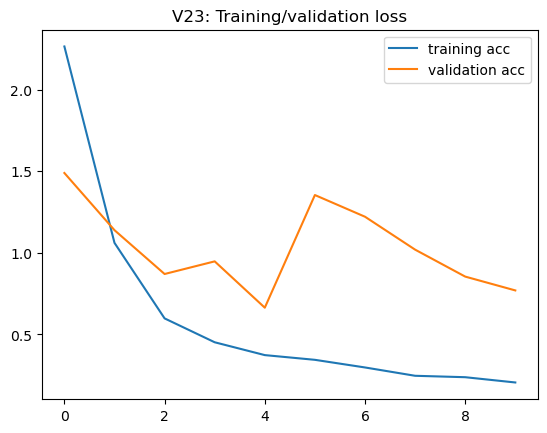

372/372 [==============================] - 4s 10ms/step - loss: 0.1852 - accuracy: 1.0000
Training model v24 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.2, learning_rate=0.0001]
Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_177 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_177 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_177 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_178 (Conv2D)         (None, 72, 72, 32)        9248      
 

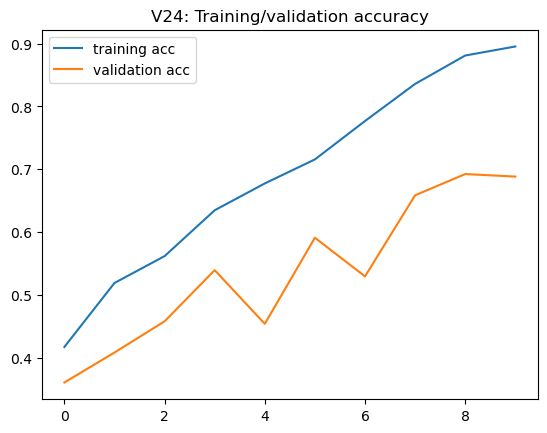

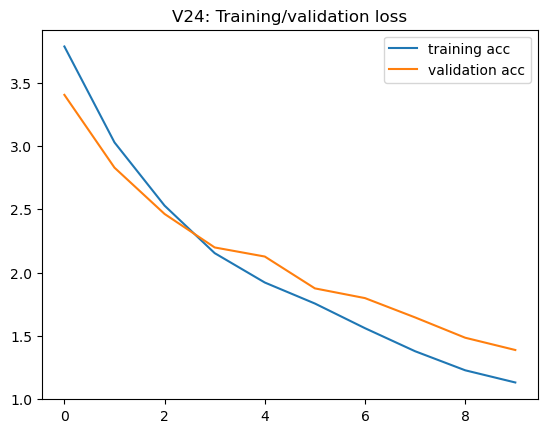

372/372 [==============================] - 4s 10ms/step - loss: 1.3337 - accuracy: 0.7957
Training model v25 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.5, learning_rate=0.01]
Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_180 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_180 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_180 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_181 (Conv2D)         (None, 72, 72, 32)        9248      
   

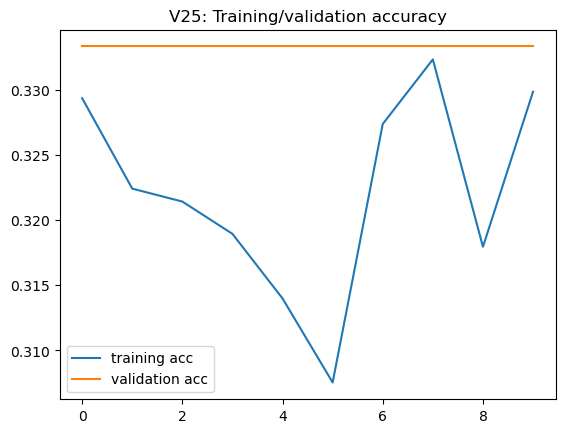

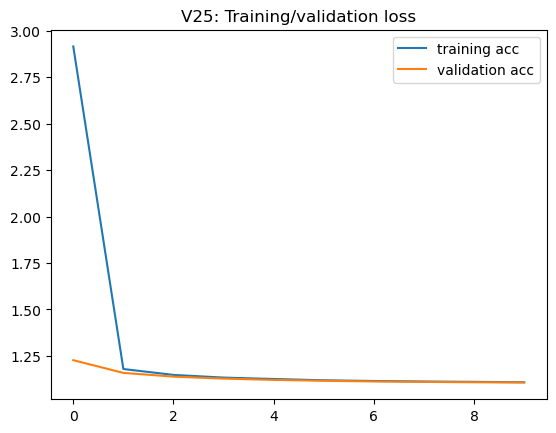

372/372 [==============================] - 4s 10ms/step - loss: 1.1067 - accuracy: 0.3333
Training model v26 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.5, learning_rate=0.001]
Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_183 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_183 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_184 (Conv2D)         (None, 72, 72, 32)        9248      
  

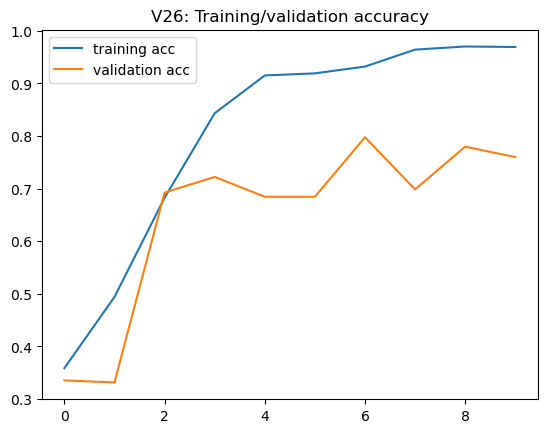

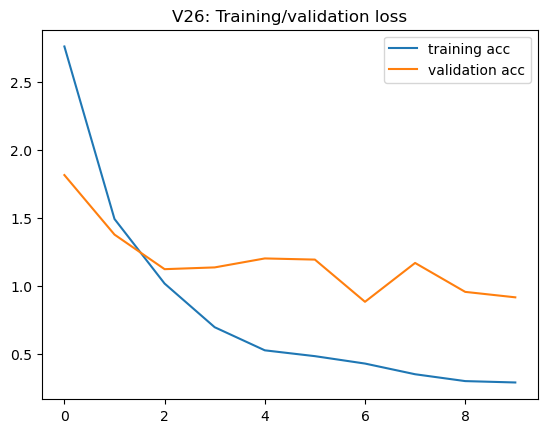

372/372 [==============================] - 4s 10ms/step - loss: 0.2839 - accuracy: 0.9812
Training model v27 (/54)! [size_dense_1=128, size_dense_2=32, drop_rate=0.5, learning_rate=0.0001]
Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_186 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_186 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_186 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_187 (Conv2D)         (None, 72, 72, 32)        9248      
 

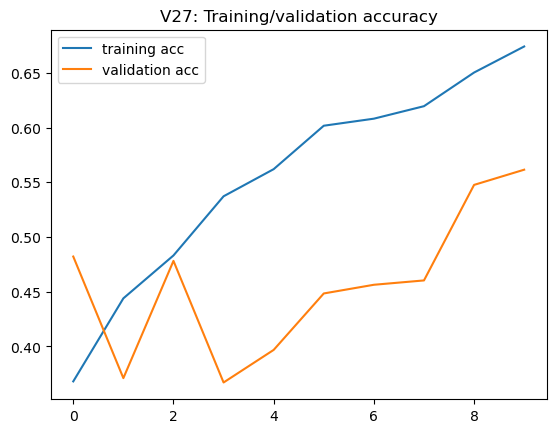

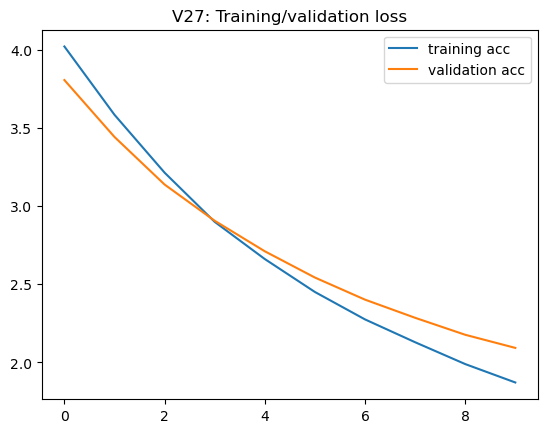

372/372 [==============================] - 4s 9ms/step - loss: 2.0727 - accuracy: 0.7419
Training model v28 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.0, learning_rate=0.01]
Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_189 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_189 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_189 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_190 (Conv2D)         (None, 72, 72, 32)        9248      
    

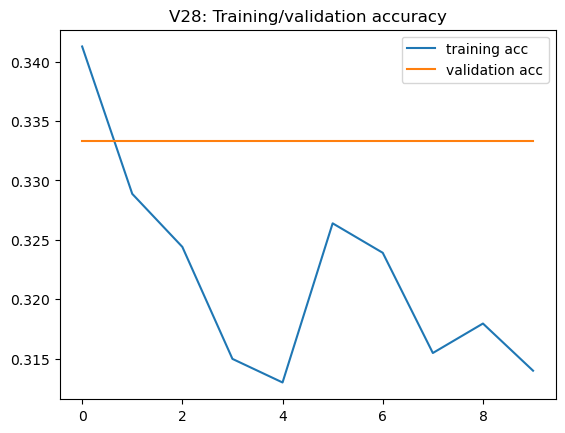

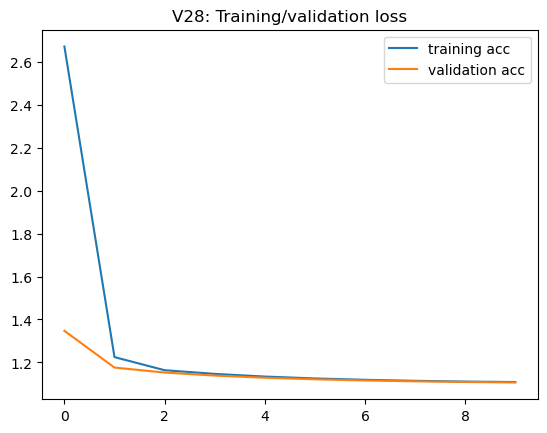

372/372 [==============================] - 3s 9ms/step - loss: 1.1066 - accuracy: 0.3333
Training model v29 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.0, learning_rate=0.001]
Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_192 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_192 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_192 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_193 (Conv2D)         (None, 72, 72, 32)        9248      
   

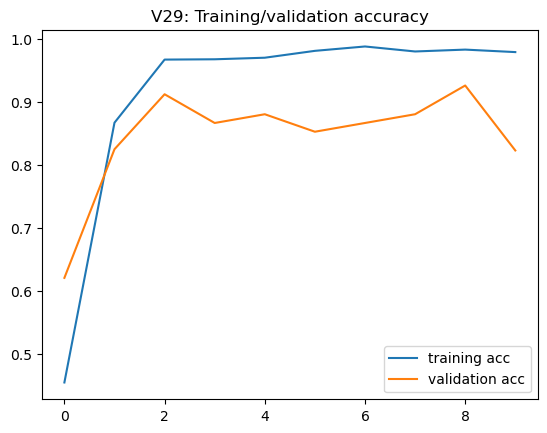

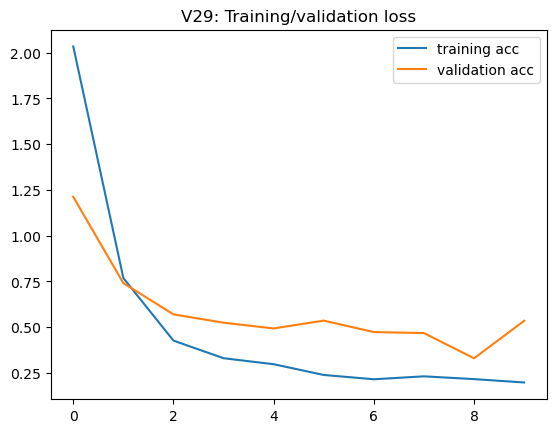

372/372 [==============================] - 4s 10ms/step - loss: 0.2573 - accuracy: 0.9677
Training model v30 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.0, learning_rate=0.0001]
Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_195 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_195 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_195 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_196 (Conv2D)         (None, 72, 72, 32)        9248      
 

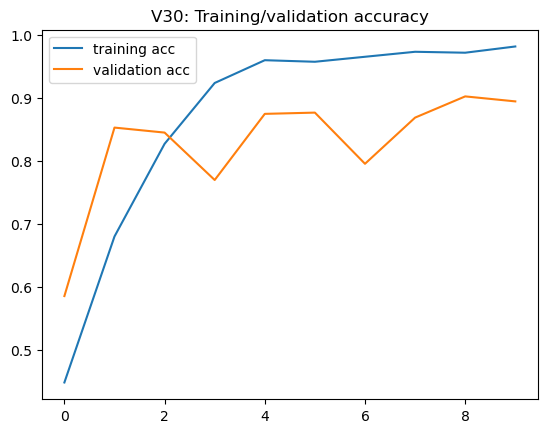

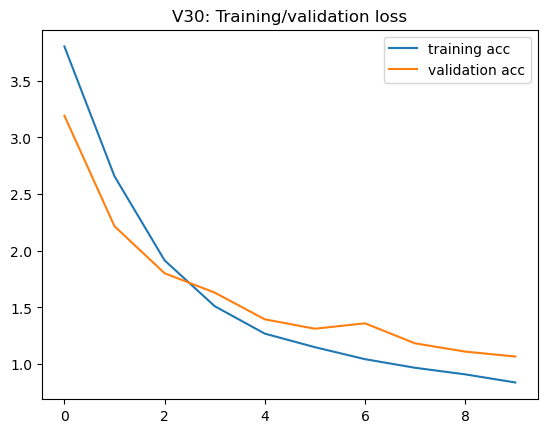

372/372 [==============================] - 3s 9ms/step - loss: 0.8962 - accuracy: 0.9543
Training model v31 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.2, learning_rate=0.01]
Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_198 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_198 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_198 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_199 (Conv2D)         (None, 72, 72, 32)        9248      
    

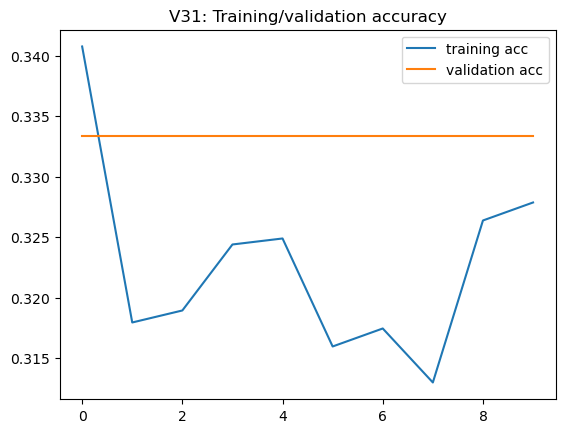

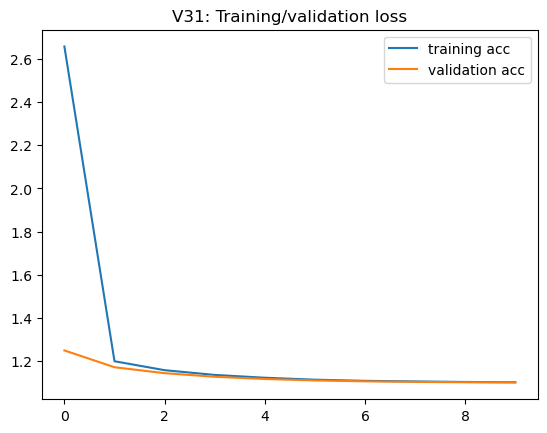

372/372 [==============================] - 4s 10ms/step - loss: 1.1016 - accuracy: 0.3333
Training model v32 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.2, learning_rate=0.001]
Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_201 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_201 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_201 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_202 (Conv2D)         (None, 72, 72, 32)        9248      
  

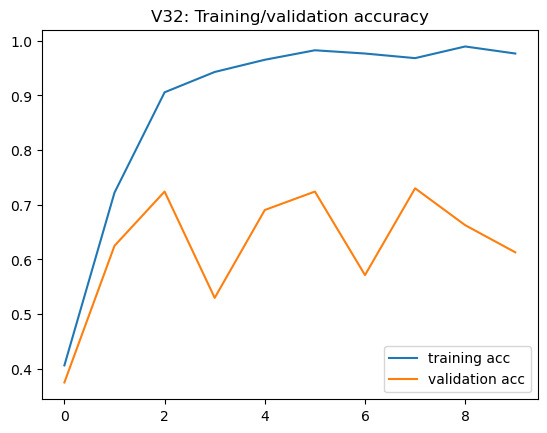

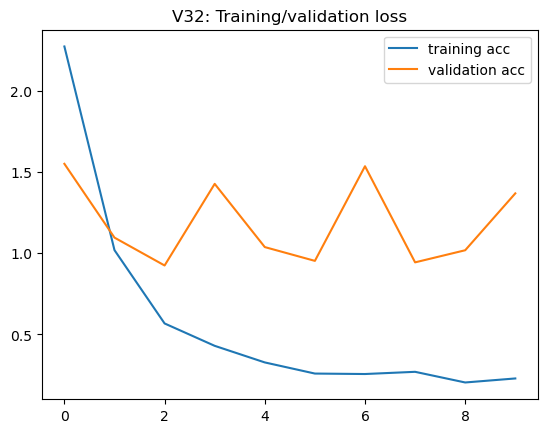

372/372 [==============================] - 4s 10ms/step - loss: 0.2278 - accuracy: 0.9812
Training model v33 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.2, learning_rate=0.0001]
Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_204 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_204 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_204 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_205 (Conv2D)         (None, 72, 72, 32)        9248      
 

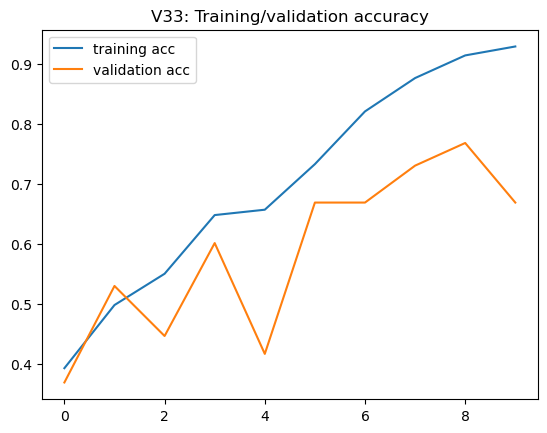

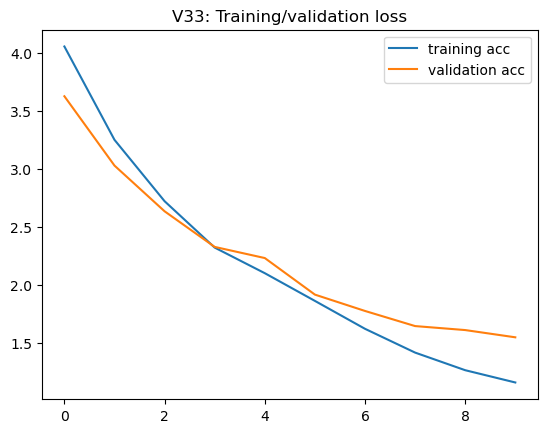

372/372 [==============================] - 4s 10ms/step - loss: 1.1968 - accuracy: 0.9194
Training model v34 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.5, learning_rate=0.01]
Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_207 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_207 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_207 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_208 (Conv2D)         (None, 72, 72, 32)        9248      
   

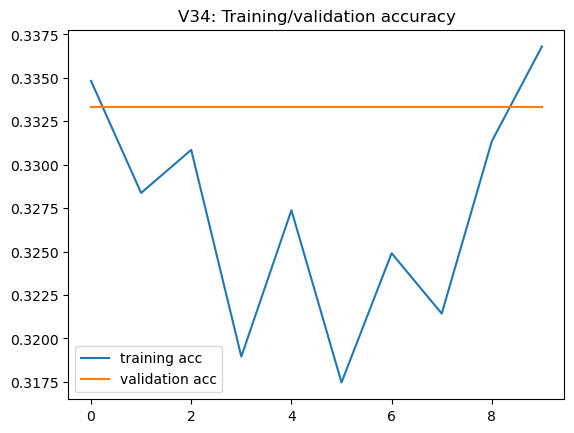

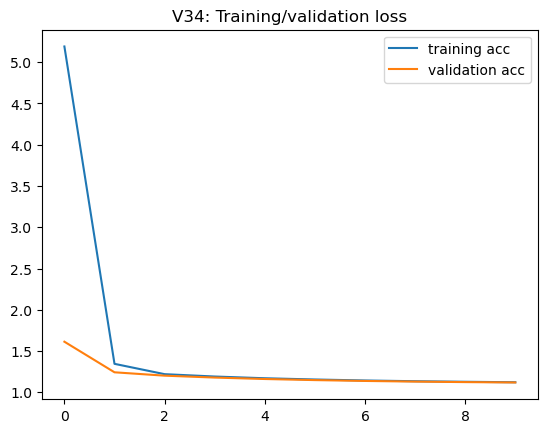

372/372 [==============================] - 4s 10ms/step - loss: 1.1190 - accuracy: 0.3333
Training model v35 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.5, learning_rate=0.001]
Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_210 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_210 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_210 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_211 (Conv2D)         (None, 72, 72, 32)        9248      
  

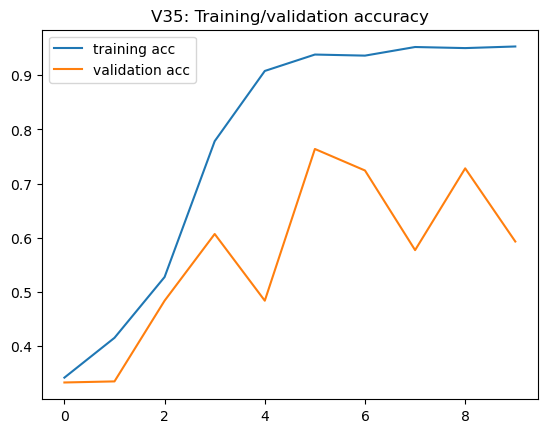

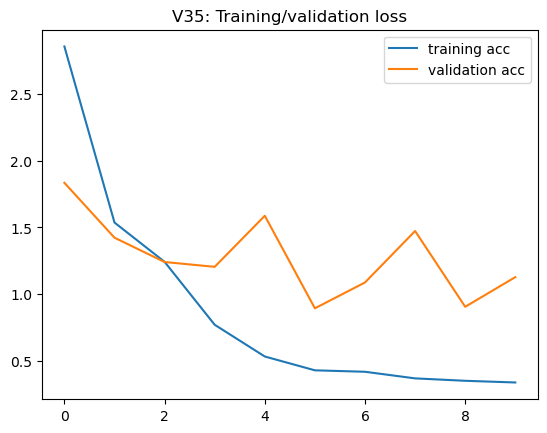

372/372 [==============================] - 3s 9ms/step - loss: 0.3313 - accuracy: 0.9704
Training model v36 (/54)! [size_dense_1=128, size_dense_2=64, drop_rate=0.5, learning_rate=0.0001]
Model: "model_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_213 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_213 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_213 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_214 (Conv2D)         (None, 72, 72, 32)        9248      
  

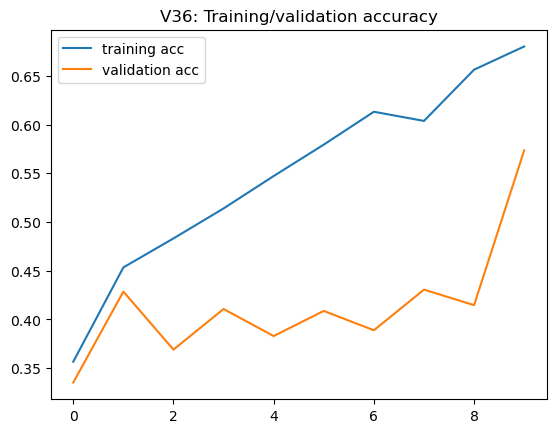

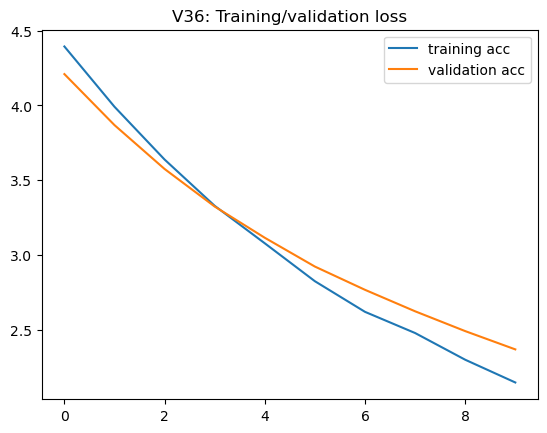

372/372 [==============================] - 3s 9ms/step - loss: 2.3571 - accuracy: 0.5081
Training model v37 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.0, learning_rate=0.01]
Model: "model_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_216 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_216 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_216 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_217 (Conv2D)         (None, 72, 72, 32)        9248      
    

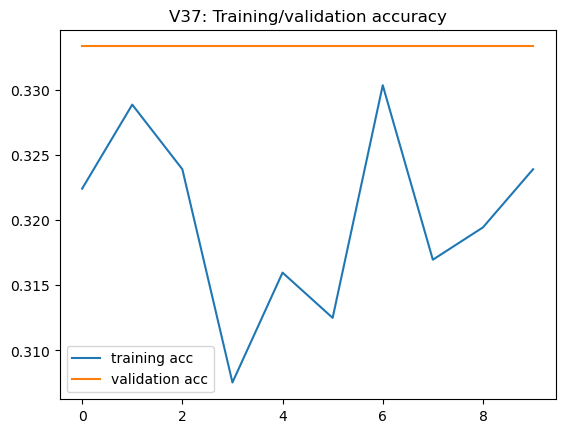

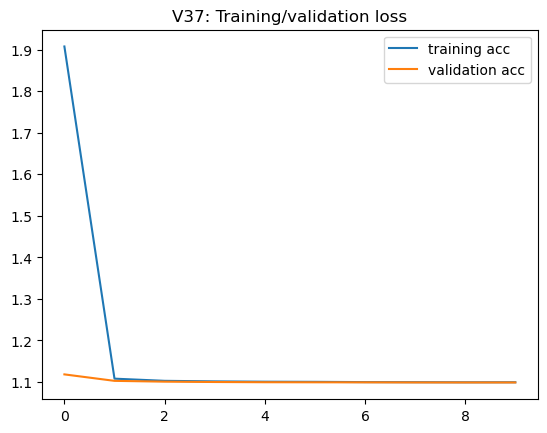

372/372 [==============================] - 4s 11ms/step - loss: 1.0987 - accuracy: 0.3333
Training model v38 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.0, learning_rate=0.001]
Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_219 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_219 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_219 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_220 (Conv2D)         (None, 72, 72, 32)        9248      
  

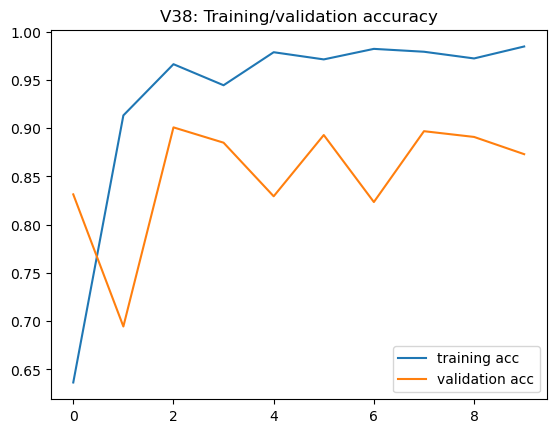

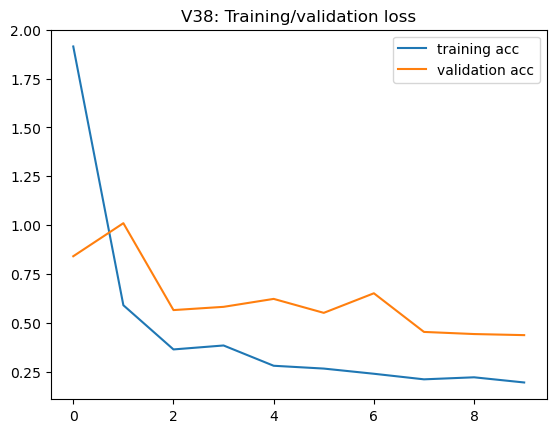

372/372 [==============================] - 4s 11ms/step - loss: 0.2702 - accuracy: 0.9409
Training model v39 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.0, learning_rate=0.0001]
Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_222 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_222 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_222 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_223 (Conv2D)         (None, 72, 72, 32)        9248      
 

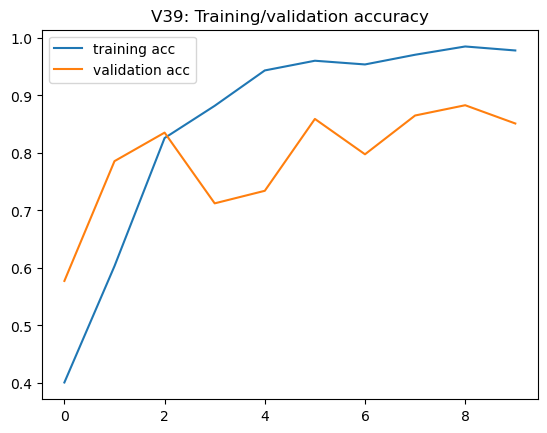

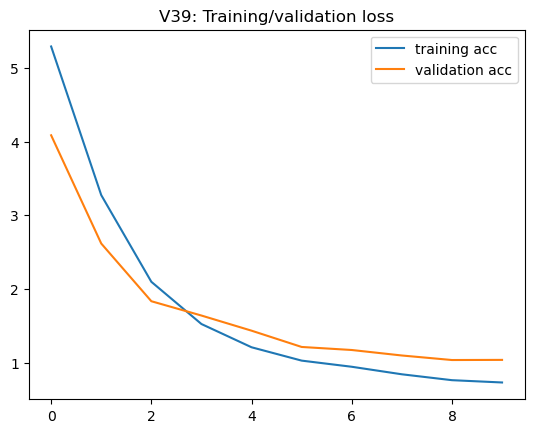

372/372 [==============================] - 4s 10ms/step - loss: 0.7389 - accuracy: 0.9758
Training model v40 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.2, learning_rate=0.01]
Model: "model_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_225 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_225 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_225 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_226 (Conv2D)         (None, 72, 72, 32)        9248      
   

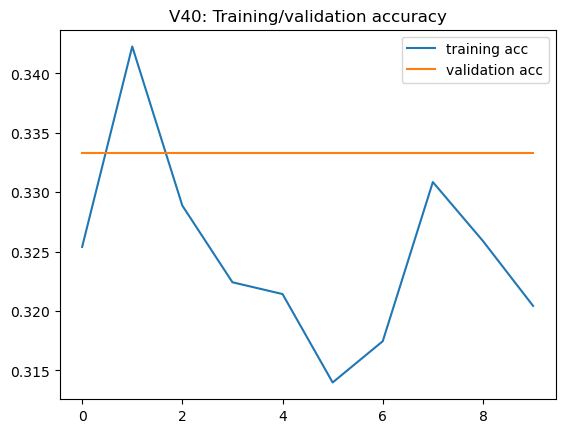

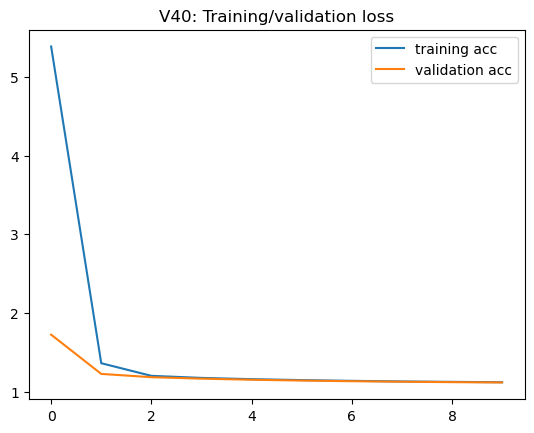

372/372 [==============================] - 4s 11ms/step - loss: 1.1165 - accuracy: 0.3333
Training model v41 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.2, learning_rate=0.001]
Model: "model_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_77 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_228 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_228 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_228 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_229 (Conv2D)         (None, 72, 72, 32)        9248      
  

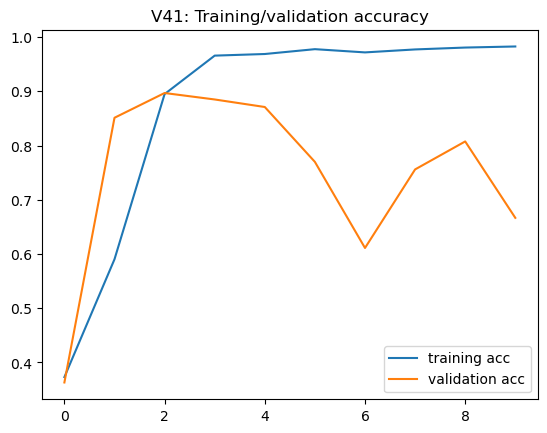

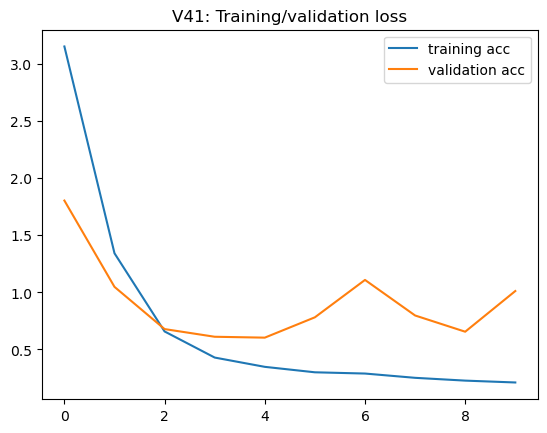

372/372 [==============================] - 4s 11ms/step - loss: 0.2277 - accuracy: 0.9731
Training model v42 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.2, learning_rate=0.0001]
Model: "model_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_231 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_231 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_231 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_232 (Conv2D)         (None, 72, 72, 32)        9248      
 

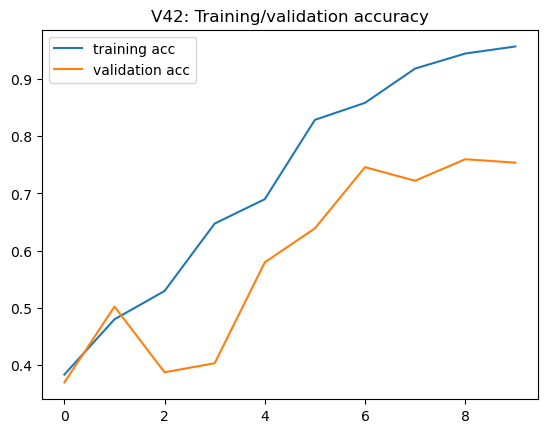

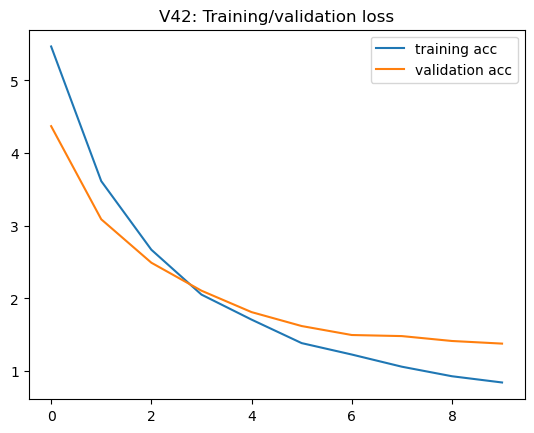

372/372 [==============================] - 4s 12ms/step - loss: 0.9701 - accuracy: 0.8952
Training model v43 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.5, learning_rate=0.01]
Model: "model_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_234 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_234 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_234 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_235 (Conv2D)         (None, 72, 72, 32)        9248      
   

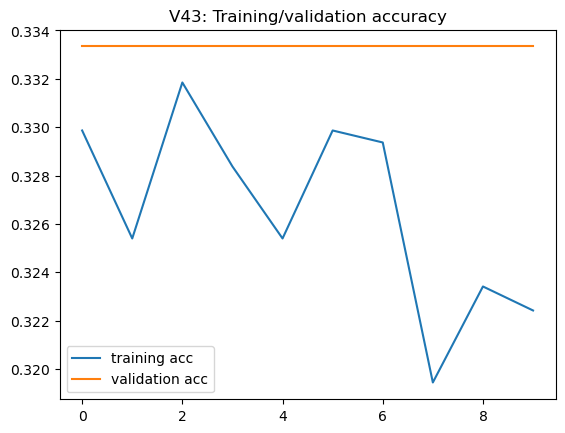

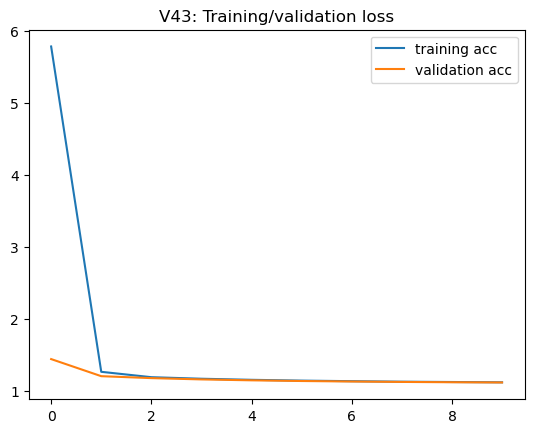

372/372 [==============================] - 4s 11ms/step - loss: 1.1134 - accuracy: 0.3333
Training model v44 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.5, learning_rate=0.001]
Model: "model_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_237 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_237 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_237 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_238 (Conv2D)         (None, 72, 72, 32)        9248      
  

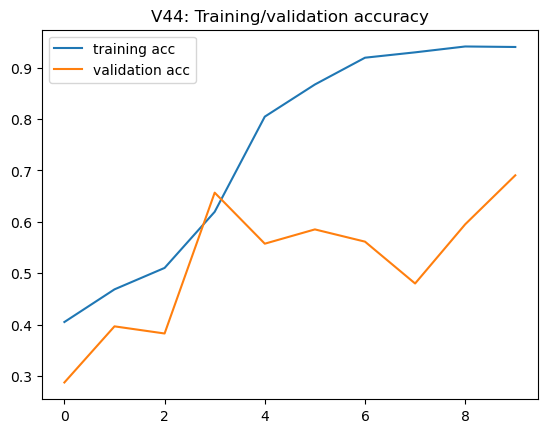

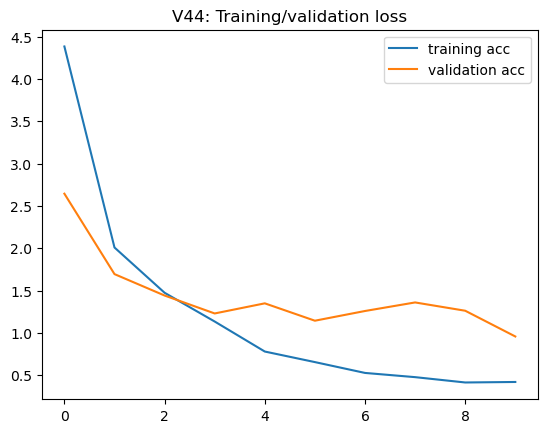

372/372 [==============================] - 4s 11ms/step - loss: 0.4976 - accuracy: 0.9274
Training model v45 (/54)! [size_dense_1=256, size_dense_2=32, drop_rate=0.5, learning_rate=0.0001]
Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_81 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_240 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_240 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_240 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_241 (Conv2D)         (None, 72, 72, 32)        9248      
 

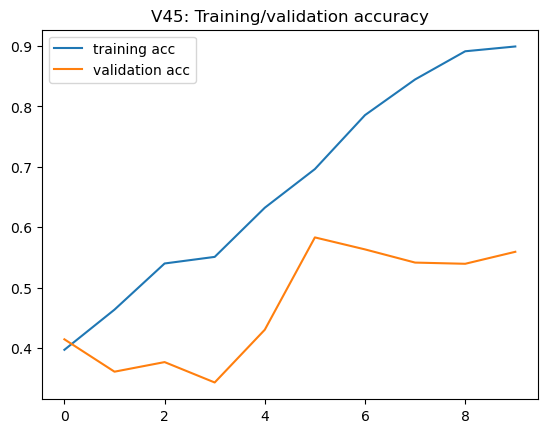

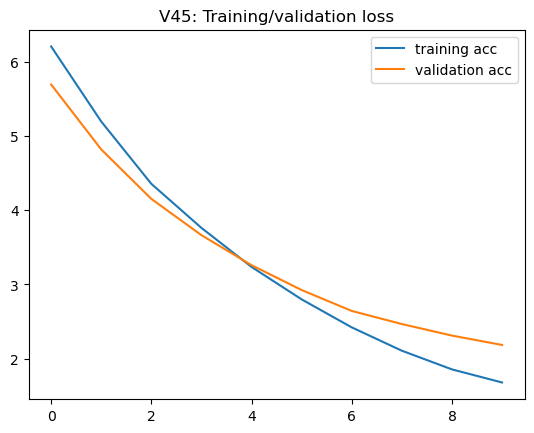

372/372 [==============================] - 5s 12ms/step - loss: 1.7665 - accuracy: 0.8952
Training model v46 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.0, learning_rate=0.01]
Model: "model_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_82 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_243 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_243 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_243 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_244 (Conv2D)         (None, 72, 72, 32)        9248      
   

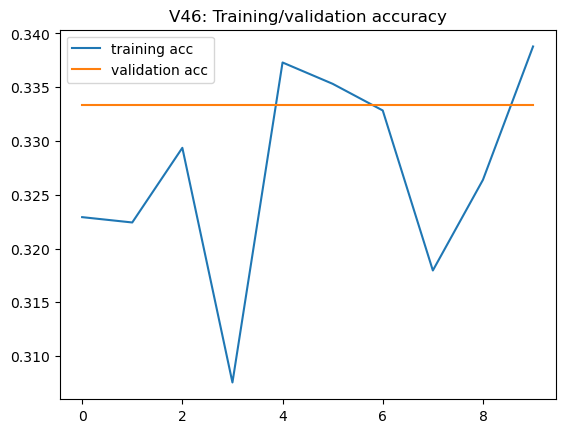

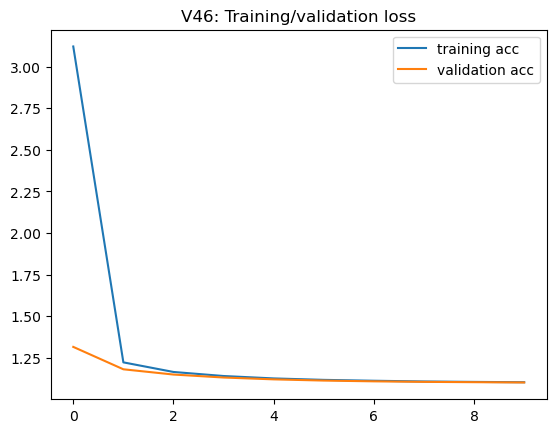

372/372 [==============================] - 4s 11ms/step - loss: 1.1026 - accuracy: 0.3333
Training model v47 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.0, learning_rate=0.001]
Model: "model_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_83 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_246 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_246 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_246 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_247 (Conv2D)         (None, 72, 72, 32)        9248      
  

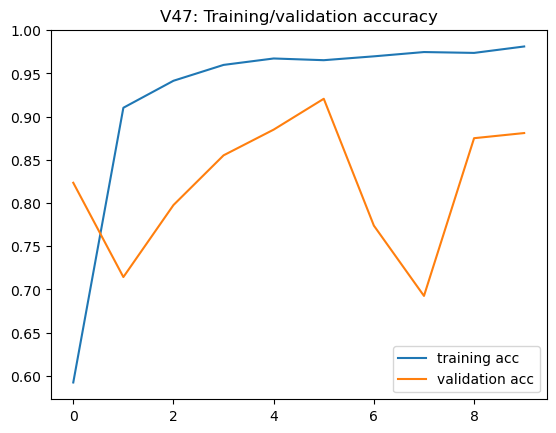

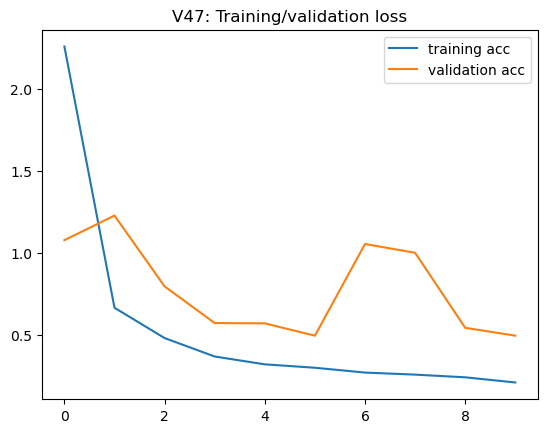

372/372 [==============================] - 4s 11ms/step - loss: 0.3117 - accuracy: 0.9194
Training model v48 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.0, learning_rate=0.0001]
Model: "model_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_84 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_249 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_249 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_249 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_250 (Conv2D)         (None, 72, 72, 32)        9248      
 

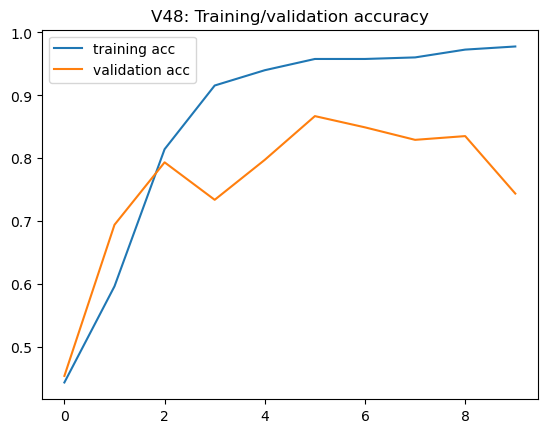

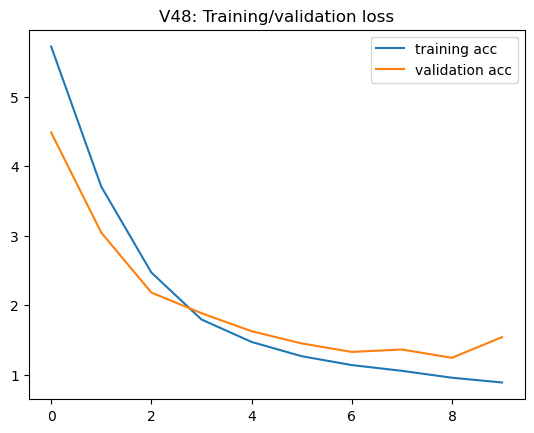

372/372 [==============================] - 4s 11ms/step - loss: 0.8982 - accuracy: 0.9731
Training model v49 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.2, learning_rate=0.01]
Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_85 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_252 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_252 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_252 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_253 (Conv2D)         (None, 72, 72, 32)        9248      
   

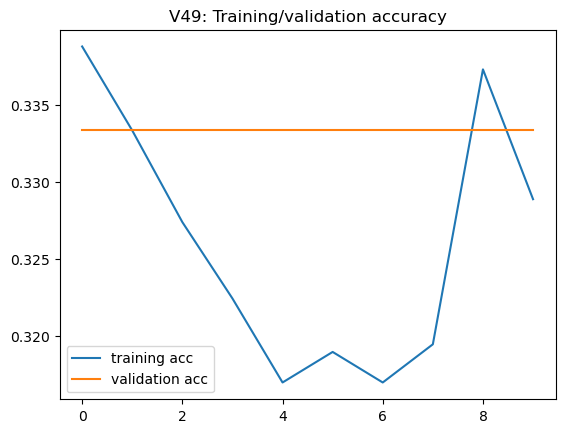

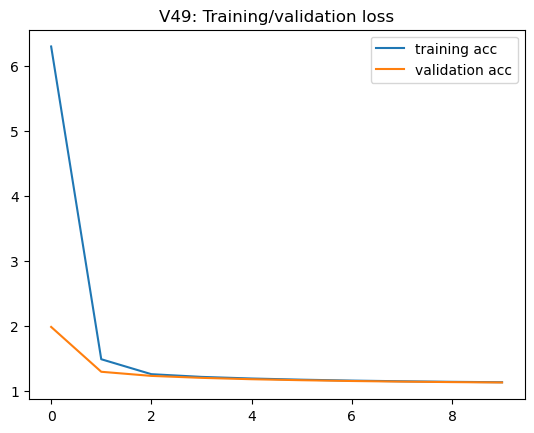

372/372 [==============================] - 4s 11ms/step - loss: 1.1259 - accuracy: 0.3333
Training model v50 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.2, learning_rate=0.001]
Model: "model_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_255 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_255 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_255 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_256 (Conv2D)         (None, 72, 72, 32)        9248      
  

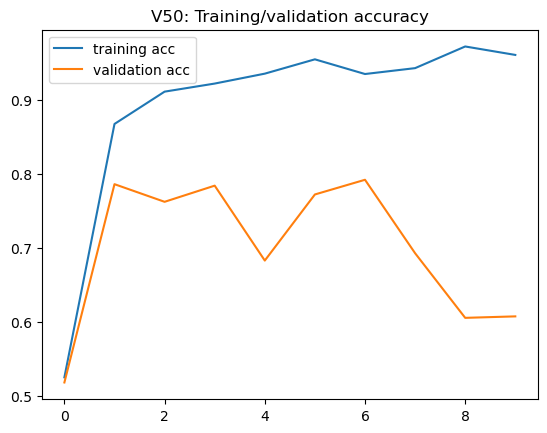

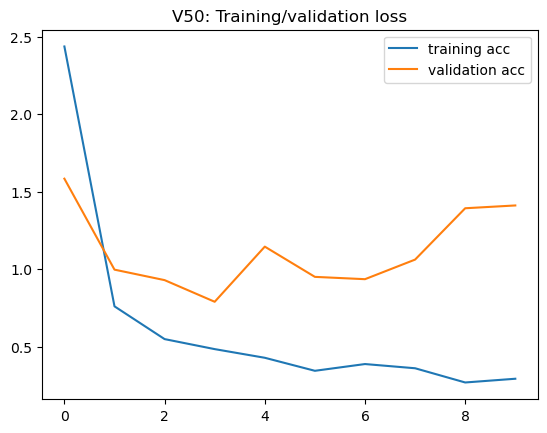

372/372 [==============================] - 4s 11ms/step - loss: 0.3038 - accuracy: 0.9624
Training model v51 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.2, learning_rate=0.0001]
Model: "model_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_87 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_258 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_258 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_258 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_259 (Conv2D)         (None, 72, 72, 32)        9248      
 

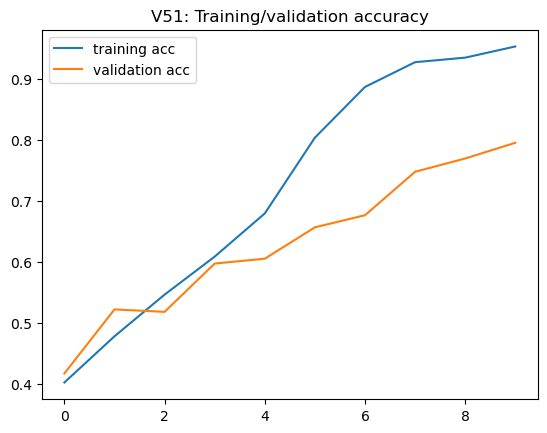

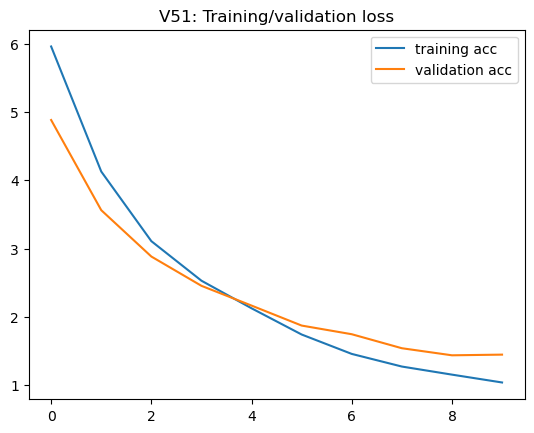

372/372 [==============================] - 4s 11ms/step - loss: 1.0771 - accuracy: 0.9462
Training model v52 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.5, learning_rate=0.01]
Model: "model_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_261 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_261 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_261 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_262 (Conv2D)         (None, 72, 72, 32)        9248      
   

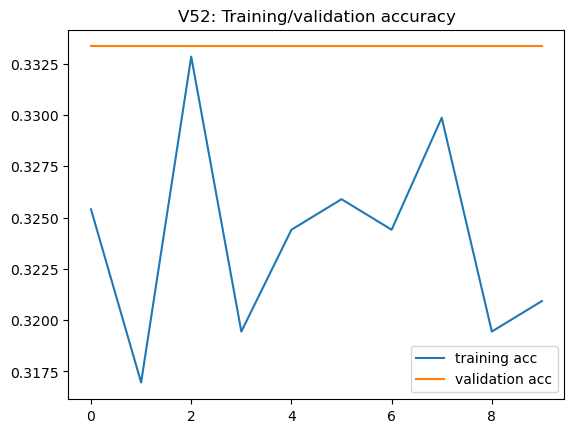

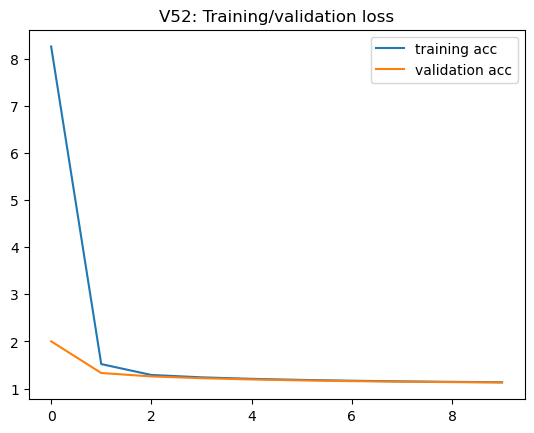

372/372 [==============================] - 4s 11ms/step - loss: 1.1293 - accuracy: 0.3333
Training model v53 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.5, learning_rate=0.001]
Model: "model_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_89 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_264 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_264 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_264 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_265 (Conv2D)         (None, 72, 72, 32)        9248      
  

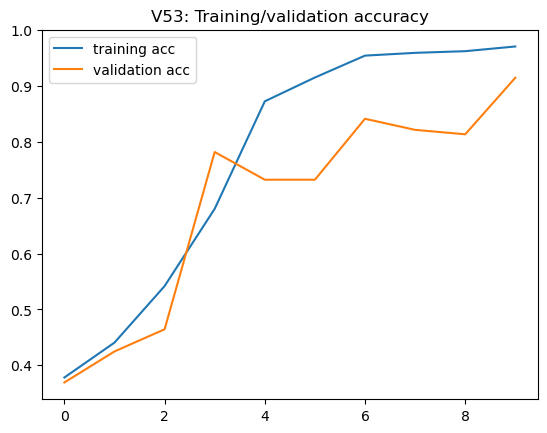

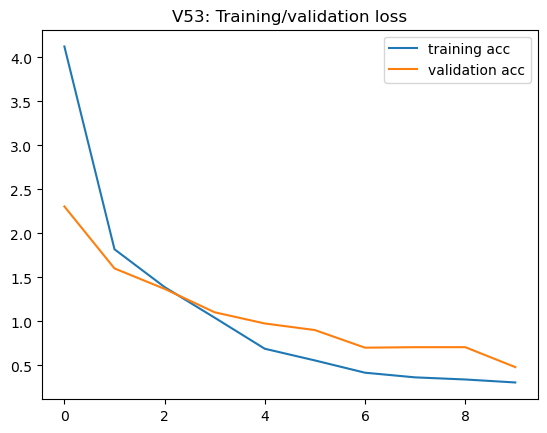

372/372 [==============================] - 4s 11ms/step - loss: 0.3064 - accuracy: 0.9651
Training model v54 (/54)! [size_dense_1=256, size_dense_2=64, drop_rate=0.5, learning_rate=0.0001]
Model: "model_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_90 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_267 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_267 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_267 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_268 (Conv2D)         (None, 72, 72, 32)        9248      
 

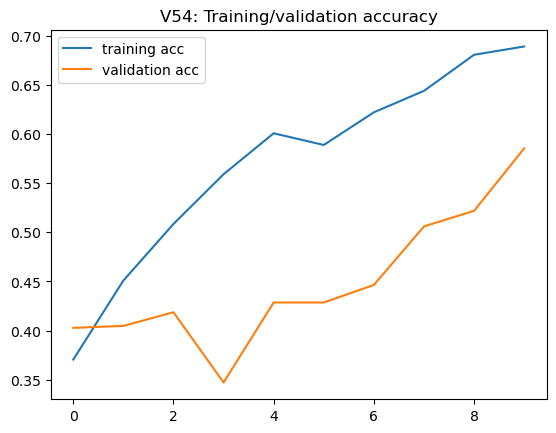

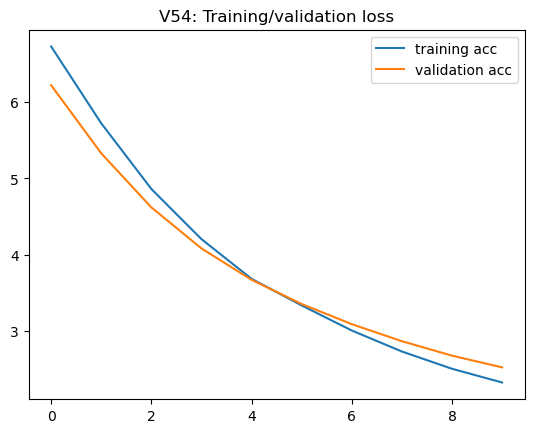

372/372 [==============================] - 4s 10ms/step - loss: 2.5220 - accuracy: 0.5161
[[1, 64, 32, 0.0, 0.01, 7.229273581504822, 0.3333333432674408], [2, 64, 32, 0.0, 0.001, 8.172601016362508, 0.9704301357269287], [3, 64, 32, 0.0, 0.0001, 7.810906267166137, 0.975806474685669], [4, 64, 32, 0.2, 0.01, 7.831274664402008, 0.3333333432674408], [5, 64, 32, 0.2, 0.001, 8.495367765426636, 0.975806474685669], [6, 64, 32, 0.2, 0.0001, 8.44201556444168, 0.8467742204666138], [7, 64, 32, 0.5, 0.01, 7.611160437266032, 0.3333333432674408], [8, 64, 32, 0.5, 0.001, 10.719759114583333, 0.9408602118492126], [9, 64, 32, 0.5, 0.0001, 10.891078468163808, 0.524193525314331], [10, 64, 64, 0.0, 0.01, 8.624086531003316, 0.3333333432674408], [11, 64, 64, 0.0, 0.001, 12.007214879989624, 0.9865591526031494], [12, 64, 64, 0.0, 0.0001, 8.62178616921107, 0.9623655676841736], [13, 64, 64, 0.2, 0.01, 7.396303097407023, 0.3333333432674408], [14, 64, 64, 0.2, 0.001, 7.5332168181737265, 0.975806474685669], [15, 64, 64

In [49]:
# Multiple experiments
version = 0
size_dense_1_list = [64, 128, 256]
size_dense_2_list = [32, 64]
drop_rate_list = [0.0, 0.2, 0.5]
learning_rate_list = [1e-2, 1e-3, 1e-4]
total_models = len(size_dense_1_list) * len(size_dense_2_list) * len(drop_rate_list) * len(learning_rate_list)

experiments = []
for size_dense_1 in size_dense_1_list:
    for size_dense_2 in size_dense_2_list:
        for drop_rate in drop_rate_list:
            for learning_rate in learning_rate_list:
                # Update version
                version += 1
                print("=============================")
                print(f"Training model v{version} (/{total_models})! [size_dense_1={size_dense_1}, size_dense_2={size_dense_2}, drop_rate={drop_rate}, learning_rate={learning_rate}]")
                
                # Create model
                model = make_model(base_model_type='custom', 
                                   num_classes=3, 
                                   input_size=input_size,
                                  size_dense_1 = size_dense_1,
                                  size_dense_2 = size_dense_2,
                                  drop_rate = drop_rate,
                                  learning_rate = learning_rate)
                print(model.summary())
                
                # Define callbacks
                checkpoint_string = f"rock_paper_scissors_v{version}_"+"{epoch:02d}_{val_accuracy:.3f}.h5"
                checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_string, 
                               save_best_only=True,
                              monitor='val_accuracy',
                              mode='max')
                            
                # Train model
                start_training = time.time()
                history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                   callbacks=[checkpoint_cb])
                training_duration_min = (time.time() - start_training) / 60
                print(f"Training took {training_duration_min} seconds.")
                
                # Plot training/validation accuracy
                plt.plot(history.history['accuracy'], label="training acc")
                plt.plot(history.history['val_accuracy'], label="validation acc")
                plt.title(f"V{version}: Training/validation accuracy")
                plt.legend()
                plt.show()
                
                # Plot training/validation loss
                plt.plot(history.history['loss'], label="training acc")
                plt.plot(history.history['val_loss'], label="validation acc")
                plt.title(f"V{version}: Training/validation loss")
                plt.legend()
                plt.show()
                
                # Evaluate model
                evaluation = model.evaluate(test_ds)
                test_acc = evaluation[1]
                
                # Recording model data
                experiments.append([version, size_dense_1, size_dense_2, drop_rate, learning_rate, training_duration_min, test_acc])

                
print(experiments)

## Save experiments data

In [50]:
experiments_df = pd.DataFrame(experiments, columns=['version', 'size_dense_1', 'size_dense_2', 
                                                    'drop_rate', 'learning_rate', 'training_duration_min', 
                                                    'test_acc'])
experiments_df.describe()

version  size_dense_1  size_dense_2  drop_rate  learning_rate  \
count  54.000000     54.000000     54.000000  54.000000      54.000000   
mean   27.500000    149.333333     48.000000   0.233333       0.003700   
std    15.732133     80.571543     16.150238   0.207410       0.004512   
min     1.000000     64.000000     32.000000   0.000000       0.000100   
25%    14.250000     64.000000     32.000000   0.000000       0.000100   
50%    27.500000    128.000000     48.000000   0.200000       0.001000   
75%    40.750000    256.000000     64.000000   0.500000       0.010000   
max    54.000000    256.000000     64.000000   0.500000       0.010000   

       training_duration_min   test_acc  
count              54.000000  54.000000  
mean                7.991751   0.704998  
std                 0.930947   0.291308  
min                 6.856462   0.333333  
25%                 7.517387   0.333333  
50%                 7.804642   0.895161  
75%                 8.197964   0.967070  
max                12.007215   1.000000

In [52]:
experiments_df.to_csv("experiments_rock_paper_scissors.csv", index=False)

## Test h5 saved model 

In [66]:
# Test a saved model
img = load_img(os.path.join(path,filename), target_size=(input_size,input_size))
img = custom_preprocess_input(img)
img = np.array([img])
test_ds.reset()
X, y = next(test_ds)
load_model = keras.models.load_model('rock_paper_scissors_v41_03_0.897.h5')
pred = load_model.predict(img)
print(pred, y)

1/1 [==============================] - 0s 168ms/step
[[0.93006283 0.00220007 0.0677371 ]] [[1. 0. 0.]]


## Save as TF SavedModel

In [68]:
# Save as SavedModel
load_model.save('rock_paper_scissors_model/41')

INFO:tensorflow:Assets written to: rock_paper_scissors_model/41/assets


INFO:tensorflow:Assets written to: rock_paper_scissors_model/41/assets
